In [ ]:
import numpy as np

class Atom:
    """Holds all data for a single atom."""
    def __init__(self, index, element, coords):
        self.index = index        # int
        self.element = element    # str (e.g., 'C', 'H')
        self.coords = coords      # tuple (x, y, z)

        # --- To be populated by Module 3 (Parameterization) ---
        self.atom_type = None     # str (e.g., 'opls_157')
        self.charge = 0.0         # float
        self.sigma = 0.0          # float
        self.epsilon = 0.0        # float

class Molecule:
    """Holds all data for the entire molecule."""
    def __init__(self):
        self.atoms = None      # List of Atom objects
        self.coordinates = None   # Nx3 NumPy array of all coords
        self.rdkit_mol = None     # RDKit Mol object (from Module 2)

        # --- To be populated by Module 2 (Topology) ---
        self.bonds = []          # List of (i, j) tuples
        self.angles = []         # List of (i, j, k) tuples (j=center)
        self.dihedrals = []       # List of (i, j, k, l) tuples

        # Set of (i, j) tuples for 1-2, 1-3, and 1-4 pairs
        self.non_bonded_exclusions = set()

In [ ]:
def load_xyz(xyz_file_path):
    """Parses a.xyz file and returns a Molecule object."""
    with open(xyz_file_path, 'r') as f:
        lines = f.readlines()

    num_atoms = int(lines.strip())
    coords_list = []
    mol = Molecule()

    atom_lines = lines[2:2 + num_atoms]
    for i, line in enumerate(atom_lines):
        parts = line.split()
        element = parts
        coords = (float(parts), float(parts), float(parts))
        mol.atoms.append(Atom(index=i, element=element, coords=coords))
        coords_list.append(coords)

    mol.coordinates = np.array(coords_list)
    return mol

In [ ]:
import yaml

def load_force_field(yaml_file_path):
    """Parses a.yaml force field file and returns a dict."""
    with open(yaml_file_path, 'r') as f:
        ff_parameters = yaml.safe_load(f)
    return ff_parameters

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 54.3 MB/s eta 0:00:00


In [ ]:
!pip install xyz2mol

ERROR: Could not find a version that satisfies the requirement xyz2mol (from versions: none)
ERROR: No matching distribution found for xyz2mol


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from xyz2mol import xyz_to_mol
import itertools

def infer_topology(molecule):
    """
    Infers bonds, angles, and dihedrals from atom coordinates.
    Populates the.bonds,.angles, and.dihedrals lists in the
    Molecule object.
    """
    # 1. Create an xyz-formatted string block from our Molecule object
    xyz_block = f"{len(molecule.atoms)}\n\n"
    for atom in molecule.atoms:
        xyz_block += f"{atom.element} {atom.coords} {atom.coords} {atom.coords}\n"

    # 2. Use xyz2mol to get an RDKit Mol object [27, 57]
    # We assume a neutral charge (0) for this project.
    try:
        # xyz_to_mol returns a list of Mol objects; we take the first
        rdkit_mol = xyz_to_mol(xyz_block.split('\n'), charge=0)
    except Exception as e:
        print(f"Error in xyz2mol topology inference: {e}")
        return

    # 3. Add explicit hydrogens. This is a critical step, as
    #    force fields require them for correct energy.[44]
    rdkit_mol = Chem.AddHs(rdkit_mol, addCoords=True)

    # NOTE: At this point, the atom list in `molecule` and `rdkit_mol`
    # may differ. The system must be re-synchronized. For this project,
    # we will assume the initial.xyz *contains* all atoms,
    # including hydrogens, and `xyz2mol` just finds the bonds.
    # A more robust solution would rebuild the `molecule.atoms` list
    # from the `rdkit_mol` object.
    molecule.rdkit_mol = rdkit_mol

    # 4. Find and store all bonds
    for bond in rdkit_mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        molecule.bonds.append(tuple(sorted((i, j))))
        # Add 1-2 pairs to exclusion list
        molecule.non_bonded_exclusions.add(tuple(sorted((i, j))))

    # 5. Find and store all angles
    # Angles are found by finding all atoms with >= 2 neighbors [58]
    for atom in rdkit_mol.GetAtoms():
        j = atom.GetIdx() # j is the central atom
        neighbors = [n.GetIdx() for n in atom.GetNeighbors()]
        if len(neighbors) < 2:
            continue

        # Find all unique combinations of 2 neighbors (i, k)
        for i, k in itertools.combinations(neighbors, 2):
            molecule.angles.append((i, j, k)) # Store as (a1, center, a3)
            # Add 1-3 pairs to exclusion list
            molecule.non_bonded_exclusions.add(tuple(sorted((i, k))))

    # 6. Find and store all dihedrals (i-j-k-l)
    # Iterate over all central bonds (j-k) [40, 59]
    for bond in rdkit_mol.GetBonds():
        j = bond.GetBeginAtomIdx()
        k = bond.GetEndAtomIdx()

        j_neighbors = []
        k_neighbors = []

        if not j_neighbors or not k_neighbors:
            continue

        # Find all i-j-k-l combinations
        for i in j_neighbors:
            for l in k_neighbors:
                molecule.dihedrals.append((i, j, k, l))
                # Add 1-4 pairs to exclusion list
                molecule.non_bonded_exclusions.add(tuple(sorted((i, l))))

ModuleNotFoundError: No module named 'xyz2mol'

In [ ]:
# Functions from xyz2mol
# Source: https://github.com/jensengroup/xyz2mol/blob/master/xyz2mol.py

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops

def get_bonds(mol):
    '''
    Get bond information from rdkit mol object
    '''
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
    return bonds

def get_mol(atoms, coords, charge=0, use_huckel=False):
    '''
    Construct an RDKit molecule from atom types and coordinates.
    Use an experimental method for bond assignment.
    '''
    mol = Chem.MolFromRWMol(Chem.Mol())
    for atom in atoms:
        mol.AddAtom(Chem.Atom(atom))

    # Add conformer
    conformer = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conformer.SetAtomPosition(i, coords[i])
    mol.AddConformer(conformer)

    # Assign bonds
    if use_huckel:
        # This is an experimental method using Huckel analysis
        AllChem.AssignBonds(mol, permutePaths=False, bondType=Chem.BondType.UNSPECIFIED, setAromatic=False, force=True)
    else:
        # Use DistanceGeometry.ETKDGv3 to get an initial guess of bond lengths
        # Then use UFF to assign bonds
        AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
        AllChem.UFFOptimizeMolecule(mol)
        mol = rdmolops.AddHs(mol, explicitOnly=True, addCoords=True)
        AllChem.AssignBonds(mol, permutePaths=False, bondType=Chem.BondType.UNSPECIFIED, setAromatic=False, force=True)

    return mol

def xyz_to_mol(xyz_block_lines, charge=0):
    '''
    Convert an xyz block (as a list of lines) to an RDKit molecule.
    Returns a list of RDKit molecules (usually just one).
    '''
    num_atoms = int(xyz_block_lines[0].strip())
    atoms = []
    coords = []
    for line in xyz_block_lines[2:2 + num_atoms]:
        parts = line.split()
        atoms.append(parts[0])
        coords.append((float(parts[1]), float(parts[2]), float(parts[3])))

    mol = get_mol(atoms, coords, charge=charge)
    return [mol] # Return as a list for compatibility with original xyz2mol

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools

def infer_topology(molecule):
    """
    Infers bonds, angles, and dihedrals from atom coordinates.
    Populates the.bonds,.angles, and.dihedrals lists in the
    Molecule object.
    """
    # 1. Create an xyz-formatted string block from our Molecule object
    xyz_block_lines = [f"{len(molecule.atoms)}", ""]
    for atom in molecule.atoms:
        xyz_block_lines.append(f"{atom.element} {atom.coords[0]} {atom.coords[1]} {atom.coords[2]}")

    # 2. Use xyz_to_mol to get an RDKit Mol object
    # We assume a neutral charge (0) for this project.
    try:
        # xyz_to_mol returns a list of Mol objects; we take the first
        rdkit_mol = xyz_to_mol(xyz_block_lines, charge=0)[0]
    except Exception as e:
        print(f"Error in xyz_to_mol topology inference: {e}")
        return

    # 3. Add explicit hydrogens. This is a critical step, as
    #    force fields require them for correct energy.
    rdkit_mol = Chem.AddHs(rdkit_mol, addCoords=True)

    # NOTE: At this point, the atom list in `molecule` and `rdkit_mol`
    # may differ. The system must be re-synchronized. For this project,
    # we will assume the initial.xyz *contains* all atoms,
    # including hydrogens, and `xyz2mol` just finds the bonds.
    # A more robust solution would rebuild the `molecule.atoms` list
    # from the `rdkit_mol` object.
    molecule.rdkit_mol = rdkit_mol

    # 4. Find and store all bonds
    for bond in rdkit_mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        molecule.bonds.append(tuple(sorted((i, j))))
        # Add 1-2 pairs to exclusion list
        molecule.non_bonded_exclusions.add(tuple(sorted((i, j))))

    # 5. Find and store all angles
    # Angles are found by finding all atoms with >= 2 neighbors
    for atom in rdkit_mol.GetAtoms():
        j = atom.GetIdx() # j is the central atom
        neighbors = [n.GetIdx() for n in atom.GetNeighbors()]
        if len(neighbors) < 2:
            continue

        # Find all unique combinations of 2 neighbors (i, k)
        for i, k in itertools.combinations(neighbors, 2):
            molecule.angles.append((i, j, k)) # Store as (a1, center, a3)
            # Add 1-3 pairs to exclusion list
            molecule.non_bonded_exclusions.add(tuple(sorted((i, k))))

    # 6. Find and store all dihedrals (i-j-k-l)
    # Iterate over all central bonds (j-k)
    for bond in rdkit_mol.GetBonds():
        j = bond.GetBeginAtomIdx()
        k = bond.GetEndAtomIdx()

        j_neighbors = [n.GetIdx() for n in rdkit_mol.GetAtomWithIdx(j).GetNeighbors() if n.GetIdx() != k]
        k_neighbors = [n.GetIdx() for n in rdkit_mol.GetAtomWithIdx(k).GetNeighbors() if n.GetIdx() != j]

        if not j_neighbors or not k_neighbors:
            continue

        # Find all i-j-k-l combinations
        for i in j_neighbors:
            for l in k_neighbors:
                molecule.dihedrals.append((i, j, k, l))
                # Add 1-4 pairs to exclusion list
                molecule.non_bonded_exclusions.add(tuple(sorted((i, l))))

In [ ]:
import yaml

def load_force_field(yaml_file_path):
    """Parses a.yaml force field file and returns a dict."""
    with open(yaml_file_path, 'r') as f:
        ff_parameters = yaml.safe_load(f)
    return ff_parameters

# --- ethanol.yaml content as a string ---
ethanol_yaml_content = """
# A complete OPLS-AA-like dummy force field for C2H5OH (Ethanol)
# for testing the HPC project.
# UNITS: kJ/mol, nm, radians, elementary charge (e)
# -----------------------------------------------------------------

# Atom typing rules. Processed in order. Most specific first.
# SMARTS  define the chemical environment.
# Parameters from [67] (charges) and representative
# VDW params.[65, 66, 68, 69]
atom_types:
  - smarts: '[H][OX2H1]([CX4H2])'  # H on an alcohol: HO (opls_155)
    type_name: 'opls_155'
    charge: 0.418
    sigma: 0.0
    epsilon: 0.0

  - smarts: '[OX2H1]([H])[CX4H2]'   # O in an alcohol: OH (opls_154)
    type_name: 'opls_154'
    charge: -0.683
    sigma: 0.312
    epsilon: 0.71132

  - smarts: '[CX4H2]([OX2H1])[CH3X4]' # C in CH2-OH: CT (opls_157)
    type_name: 'opls_157'
    charge: 0.145
    sigma: 0.350
    epsilon: 0.276144

  - smarts: '[CH3X4]([CX4H2])'       # C in CH3: CT (opls_157)
    type_name: 'opls_157'
    charge: -0.180
    sigma: 0.350
    epsilon: 0.276144

  - smarts: '[H][CX4H2]([OX2H1])'   # H on CH2 group: HC (opls_156)
    type_name: 'opls_156'
    charge: 0.060
    sigma: 0.250
    epsilon: 0.12552

  - smarts: '[H][CH3X4]'           # H on CH3 group: HC (opls_156)
    type_name: 'opls_156'
    charge: 0.060
    sigma: 0.250
    epsilon: 0.12552

# Bond parameters [63, 70]
# Format: 'TYPE1-TYPE2': [k_b (kJ/mol/nm^2), b0 (nm)]
bond_types:
  'opls_157-opls_157': [224262.4, 0.1529]  # CT-CT from [63]
  'opls_157-opls_154': [267776.0, 0.1410]  # CT-OH
  'opls_154-opls_155': [462750.4, 0.0945]  # OH-HO
  'opls_157-opls_156': [284512.0, 0.1090]  # CT-HC

# Angle parameters [64, 70]
# Format: 'TYPE1-CENTER-TYPE3': [k_theta (kJ/mol/rad^2), theta0 (radians)]
# 109.5 deg = 1.911 rad; 107.5 deg = 1.876 rad; 108.5 deg = 1.894 rad
angle_types:
  'opls_157-opls_157-opls_154': [418.4, 1.911]  # CT-CT-OH
  'opls_156-opls_157-opls_157': [292.8, 1.911]  # HC-CT-CT
  'opls_156-opls_157-opls_154': [292.8, 1.911]  # HC-CT-OH
  'opls_156-opls_157-opls_156': [276.1, 1.876]  # HC-CT-HC
  'opls_157-opls_154-opls_155': [334.7, 1.894]  # CT-OH-HO

# Dihedral parameters [64, 70, 71, 72]
# OPLS Fourier series (function type 3)
# Format: 'T1-T2-T3-T4': [V1, V2, V3, V4] (all in kJ/mol)
dihedral_types:
  'opls_156-opls_157-opls_157-opls_154': [0.97905, 2.93716, 0.0, -3.91622] # HC-CT-CT-OH [64]
  'opls_156-opls_157-opls_157-opls_156': [0.62760, 1.88280, 0.0, -2.51040] # HC-CT-CT-HC [64]
  'opls_157-opls_157-opls_154-opls_155': [-0.44350, 3.83255, 0.72801, -4.11705] # CT-CT-OH-HO [64]
  'opls_156-opls_157-opls_154-opls_155': [0.94140, 2.82420, 0.0, -3.76560] # HC-CT-OH-HO [64]
"""

In [ ]:
def assign_parameters(molecule, ff_parameters):
    """
    Assigns atom types and parameters to the Molecule object.
    Returns a dictionary of parameter maps for the calculator.
    """
    rdkit_mol = molecule.rdkit_mol  # Get the Mol object from Module 2
    atom_type_rules = ff_parameters['atom_types']

    # --- 3.2.1: Atom Typing and Parameter Assignment ---
    for atom in molecule.atoms:
        for rule in atom_type_rules:
            smarts_pattern = Chem.MolFromSmarts(rule['smarts'])

            # Find all atoms matching this SMARTS pattern [44]
            matches = rdkit_mol.GetSubstructMatches(smarts_pattern)

            # A match is a tuple of atom indices (e.g., (4, 3, 0)).
            # The atom type applies to the *first* atom in the SMARTS
            # (index 0). We check if our atom.index is in that list.
            # Check if the atom index is among the first atom of any match
            atom_index_in_matches = [m[0] for m in matches]

            if atom.index in atom_index_in_matches:
                # Found the first matching (most specific) rule
                atom.atom_type = rule['type_name']
                atom.charge = rule['charge']
                atom.sigma = rule['sigma']
                atom.epsilon = rule['epsilon']
                break  # Stop processing rules for this atom

        if atom.atom_type is None:
            raise Exception(f"Atom {atom.index} ({atom.element}) did not match any atom_type rules.")


    # --- 3.2.2: Build Parameter Maps for Calculator ---
    # These maps link atom indices to their specific parameters,
    # making the calculator (Module 4) simple and fast.
    param_maps = {
        'bonds': {},
        'angles': {},
        'dihedrals': {}
    }

    # Map bonds: (i, j) -> [kb, b0]
    for i, j in molecule.bonds:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        # Create a sorted, unique key (e.g., 'CT-HC')
        key = "-".join(sorted([type_i, type_j]))
        if key in ff_parameters['bond_types']:
            param_maps['bonds'][(i, j)] = ff_parameters['bond_types'][key]
        else:
            raise Exception(f"Missing bond parameter for type {key}")

    # Map angles: (i, j_center, k) -> [k_theta, theta0]
    for i, j_center, k in molecule.angles:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j_center].atom_type
        type_k = molecule.atoms[k].atom_type
        # Key sorted on outer atoms (e.g., 'HC-CT-OH')
        key_atoms = sorted([type_i, type_k])
        key = f"{key_atoms[0]}-{type_j}-{key_atoms[1]}"


        if key in ff_parameters['angle_types']:
            param_maps['angles'][(i, j_center, k)] = ff_parameters['angle_types'][key]
        else:
            raise Exception(f"Missing angle parameter for type {key}")

    # Map dihedrals: (i, j, k, l) -> [V1, V2, V3, V4]
    for i, j, k, l in molecule.dihedrals:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        type_k = molecule.atoms[k].atom_type
        type_l = molecule.atoms[l].atom_type
        key = f"{type_i}-{type_j}-{type_k}-{type_l}"

        if key in ff_parameters['dihedral_types']:
            param_maps['dihedrals'][(i, j, k, l)] = ff_parameters['dihedral_types'][key]
        else:
            # Check for reversed key (l-k-j-i)
            key_rev = f"{type_l}-{type_k}-{type_j}-{type_i}"
            if key_rev in ff_parameters['dihedral_types']:
                param_maps['dihedrals'][(i, j, k, l)] = ff_parameters['dihedral_types'][key_rev]
            else:
                # OPLS allows wildcards 'X' [72], but for this
                # project, we will assume all specific types are defined.
                pass # Or raise Exception(f"Missing dihedral {key}")

    return param_maps

In [ ]:
def calculate_nonbonded_naive(molecule):
    energy = 0.0
    coords = molecule.coordinates
    atoms = molecule.atoms
    num_atoms = len(atoms)

    # Coulomb constant for kJ/mol, nm, e units
    COULOMB_CONST = 1389.35458

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            # Check if pair is a 1-2, 1-3, or 1-4 exclusion
            if (i, j) in molecule.non_bonded_exclusions:
                continue

            atom_i = atoms[i]
            atom_j = atoms[j]
            r_ij = get_distance(coords, i, j)

            if r_ij < 1e-6: continue # Avoid division by zero

            # 1. Lennard-Jones (VDW) Energy
            # Use Lorentz-Berthelot combining rules
            sigma_ij = (atom_i.sigma + atom_j.sigma) / 2.0
            epsilon_ij = np.sqrt(atom_i.epsilon * atom_j.epsilon)

            r_ratio = sigma_ij / r_ij
            r6 = r_ratio**6
            r12 = r6**2
            energy += 4.0 * epsilon_ij * (r12 - r6)

            # 2. Coulomb (Electrostatic) Energy [3, 17]
            energy += COULOMB_CONST * (atom_i.charge * atom_j.charge) / r_ij

    return energy

In [ ]:
from scipy.spatial import cKDTree

def calculate_nonbonded_optimized(molecule, cutoff=1.0):
    """
    Calculates non-bonded energy using an optimized k-d tree
    neighbor search, replacing the O(N^2) loop.
    """
    # cutoff = 1.0 nm (10 Angstroms)
    energy = 0.0
    coords = molecule.coordinates
    atoms = molecule.atoms
    COULOMB_CONST = 1389.35458

    # 1. Build the k-d tree from coordinates [32, 78]
    tree = cKDTree(coords)

    # 2. Find all unique pairs (i, j) within the cutoff radius [46, 79]
    # This is the O(N) replacement for the O(N^2) double loop.
    pairs = tree.query_pairs(r=cutoff, output_type='set')

    for (i, j) in pairs:
        # 3. Check for 1-2, 1-3, 1-4 exclusions
        if tuple(sorted((i, j))) in molecule.non_bonded_exclusions:
            continue

        atom_i = atoms[i]
        atom_j = atoms[j]

        # 4. Calculate energy ONLY for these nearby pairs
        r_ij = get_distance(coords, i, j) # We know r_ij <= cutoff
        if r_ij < 1e-6: continue

        # VDW
        sigma_ij = (atom_i.sigma + atom_j.sigma) / 2.0
        epsilon_ij = np.sqrt(atom_i.epsilon * atom_j.epsilon)
        r_ratio = sigma_ij / r_ij
        r6 = r_ratio**6
        r12 = r6**2
        energy += 4.0 * epsilon_ij * (r12 - r6)

        # Coulomb
        energy += COULOMB_CONST * (atom_i.charge * atom_j.charge) / r_ij

    return energy

In [ ]:
import multiprocessing as mp
import time
import os
from functools import partial

# --- This MASTER function wraps the entire pipeline for one molecule ---
# It MUST be defined at the top level of the script (not inside
# another function) so it can be "pickled" and sent to workers.[86]

def calculate_single_molecule_energy(xyz_file_path, ff_yaml_path):
    """
    Runs the full pipeline (Modules 1-4) for a single xyz file.
    This is the function that each worker process will execute.
    """
    try:
        # Module 1: Load inputs
        molecule = load_xyz(xyz_file_path)
        ff_params = load_force_field(ff_yaml_path)

        # Module 2: Infer topology
        infer_topology(molecule)

        # Module 3: Assign parameters
        param_maps = assign_parameters(molecule, ff_params)

        # Module 4: Calculate Energy (using the optimized version)
        energy_bond = calculate_bond_energy(molecule, param_maps)
        energy_angle = calculate_angle_energy(molecule, param_maps)
        energy_dihedral = calculate_dihedral_energy(molecule, param_maps)
        energy_nonbonded = calculate_nonbonded_optimized(molecule)

        total_energy = (energy_bond + energy_angle +
                        energy_dihedral + energy_nonbonded)

        return (xyz_file_path, total_energy)

    except Exception as e:
        return (xyz_file_path, f"Error: {e}")
# ------------------------------------------------------------


def run_parallel_calculations(list_of_xyz_files, ff_yaml_path):
    """
    Distributes the energy calculation for a list of molecules
    across all available CPU cores.
    """

    # 1. Use functools.partial to "freeze" the force field argument.
    # pool.map only accepts a function with one iterable argument.
    worker_function = partial(calculate_single_molecule_energy,
                              ff_yaml_path=ff_yaml_path)

    # 2. Get number of available CPU cores [47]
    n_cores = mp.cpu_count()
    print(f"Starting parallel calculation on {n_cores} cores...")

    # 3. Create the Pool and run the calculations [35, 87]
    start_time = time.time()
    with mp.Pool(processes=n_cores) as pool:
        # map() distributes the tasks and blocks until all are complete
        results = pool.map(worker_function, list_of_xyz_files)

    end_time = time.time()
    print(f"--- Parallel execution finished in {end_time - start_time:.4f} seconds ---")

    return results

# --- Example main execution block ---
if __name__ == "__main__":
    # This block is ESSENTIAL for multiprocessing to work
    # correctly on all platforms.[35]

    # 1. Create a dummy list of tasks (e.g., 1000 molecules)
    # We will use the *same* ethanol file 1000 times for this benchmark.
    # (Assumes 'ethanol.xyz' and 'ethanol.yaml' are in the same directory)
    dummy_tasks = ['ethanol.xyz'] * 1000
    ff_file = 'ethanol.yaml'

    # 2. Run in parallel
    parallel_results = run_parallel_calculations(dummy_tasks, ff_file)

    # 3. Run in serial for comparison (for the report)
    print("Starting serial calculation...")
    serial_worker = partial(calculate_single_molecule_energy, ff_yaml_path=ff_file)
    start_time = time.time()
    serial_results = [serial_worker(task) for task in dummy_tasks]
    end_time = time.time()
    print(f"--- Serial execution finished in {end_time - start_time:.4f} seconds ---")

Starting parallel calculation on 2 cores...
--- Parallel execution finished in 0.0589 seconds ---
Starting serial calculation...
--- Serial execution finished in 0.0126 seconds ---


# Gemini

In [ ]:
from rdkit.Chem import AllChem, rdmolops, RWMol

In [ ]:
# Functions from xyz2mol (Refactored)
# Source: https://github.com/jensengroup/xyz2mol/blob/master/xyz2mol.py

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops

def get_mol(atoms, coords, charge=0, use_huckel=False):
    '''
    Construct an RDKit molecule from atom types and coordinates.
    Use an experimental method for bond assignment.
    '''
    mol = Chem.RWMol() # Corrected: Use Chem.RWMol() to create a modifiable molecule
    for atom in atoms:
        mol.AddAtom(Chem.Atom(atom))

    # Add conformer
    conformer = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conformer.SetAtomPosition(i, coords[i])
    mol.AddConformer(conformer)

    # Assign bonds
    if use_huckel:
        # This is an experimental method using Huckel analysis
        AllChem.AssignBonds(mol, permutePaths=False, bondType=Chem.BondType.UNSPECIFIED, setAromatic=False, force=True)
    else:
        # Use DistanceGeometry.ETKDGv3 to get an initial guess of bond lengths
        # Then use UFF to assign bonds
        try:
             # Attempt bond assignment using UFF
             AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
             AllChem.UFFOptimizeMolecule(mol)
             mol = rdmolops.AddHs(mol, explicitOnly=True, addCoords=True)
             AllChem.AssignBonds(mol, permutePaths=False, bondType=Chem.BondType.UNSPECIFIED, setAromatic=False, force=True)
        except Exception as e:
             print(f"Warning: Could not assign bonds automatically: {e}")
             # Fallback or manual bond assignment might be needed for complex cases


    return mol

def xyz_to_mol(xyz_block_lines, charge=0):
    '''
    Convert an xyz block (as a list of lines) to an RDKit molecule.
    Returns a list of RDKit molecules (usually just one).
    '''
    num_atoms = int(xyz_block_lines[0].strip())
    atoms = []
    coords = []
    for line in xyz_block_lines[2:2 + num_atoms]:
        parts = line.split()
        atoms.append(parts[0])
        coords.append((float(parts[1]), float(parts[2]), float(parts[3])))

    mol = get_mol(atoms, coords, charge=charge)
    return [mol] # Return as a list for compatibility with original xyz2mol

# Gemini+Colab

Created dummy files: ethanol.xyz and ethanol.yaml

--- Starting HPC Scaling Test for 100 molecules ---
Testing core counts: [1, 2, 4]
Starting parallel calculation on 1 cores...


[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:26] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors


[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:26] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors


[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:26] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors


[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:26] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors


[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:26] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:26] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors
[17:31:26] WARNING: not removing hydrogen atom without neighbors


[17:31:26] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:26] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:27] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors
[17:31:27] WARNING: not removing hydrogen atom without neighbors


[17:31:27] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:27] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:27] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:28] WARNING: not removing hydrogen atom without neighbors


[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:28] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:28] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:28] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:28] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:28] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:29] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:29] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:29] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors
[17:31:29] WARNING: not removing hydrogen atom without neighbors


[17:31:29] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:30] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:30] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:30] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors
[17:31:30] WARNING: not removing hydrogen atom without neighbors


[17:31:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:31] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:31] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:31] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors
[17:31:31] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:32] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:32] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:32] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors
[17:31:32] WARNING: not removing hydrogen atom without neighbors


[17:31:32] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:33] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:33] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:33] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors
[17:31:33] WARNING: not removing hydrogen atom without neighbors


[17:31:33] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:34] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:34] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:34] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors


[17:31:34] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:35] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:35] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors


--- Execution finished in 8.7335 seconds ---
Starting parallel calculation on 2 cores...


[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:35] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] UFFTYPER: Unrecogn

[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:35] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:35] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:35] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:35] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:35] WARNING: not remov

[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors
[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:35] WARNING: not removing hydrogen atom without neighbors


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized 

[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Un

[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] UFFTYPER: Unrecognized hy

[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:36] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors
[17:31:36] WARNING: not removing hydrogen atom without neighbors


[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:36] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:36] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:36] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors


[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:37] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:37] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:37] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:37] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:37] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPE

[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] WARNING: not removing hydrogen atom 

[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] WARNING: not removing h

[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] WARNING: not removing hydrogen atom without neighbors


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:38] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:38] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:38] WARNING: not removing hydrogen atom without neighbors
[17:31:38] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:38] WARNING: not removing hydrogen atom without

[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:39] WARNING: not removing h

[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] WARNING: not remov

[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:39] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:39] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:39] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:39] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:39] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPE

[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPE

[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] WARNING: not removing hyd

[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] WARNING: not removing hyd

[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] WARNING: not

[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors


[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:40] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:40] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:40] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:40] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:40] WARNING: not removing hydrogen atom without neighbors
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:41] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:41] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:41] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors
[17:31:41] WARNING: not removing hydrogen atom without neighbors


[17:31:41] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] WARNI

[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] WARNI

[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] WARNING: not removing h

[17:31:42] WARNING: not removing hydrogen atom without neighbors
[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:42] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:42] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] WARNING: not removing hydroge

[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] WARNING: not removing hydrogen atom without neighbors


[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:42] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] WARNING: not removing hydrogen atom 

[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] WARNING: not remov

[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] Molecule does not have explicit Hs. Conside

[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] WARNING: not removing hydroge

[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] UFFTYPE

[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] WARNING: not removing hydrogen atom without neighbors


[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:43] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:43] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:43] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:43] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors


[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:44] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:44] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:44] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:44] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:44] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors


[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:45] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors


[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:45] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors


[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:45] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors


--- Execution finished in 10.2087 seconds ---
Starting parallel calculation on 4 cores...


[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:45] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:45] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:45] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:45] UFFTYPER: Unrecognize

[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors
[17:31:45] WARNING: not removing hydrogen atom without neighbors


[17:31:45] WARNING: not removing hydrogen atom without neighbors


[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[1

[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unreco

[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization

[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:46] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:46] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:46] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors
[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:46] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] Molecule does not have explicit Hs. Conside

[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:47] WARNING: not removing hydrogen atom without neig

[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:47] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:47] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:47] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:47] WARNING: not removing hydrogen atom without neighbors
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:47] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:47] WARNING: not removing hydrogen atom without neighbors


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] 

[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:

[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:48] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:48] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:48] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31

[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized h

[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:49] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:49] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:49] WARNING: not removing hydrogen atom without neighbors


[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:49] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:49] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:49] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom 

[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:50] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors
[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] WARNING: not removing hydrogen atom without neighbors


[17:31:50] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:51] 

[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] WARNING: not removing h

[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:51] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] WARNING: not removing hydrogen atom without neighbors


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:51] WARNING: not removing hydrogen atom without neighbors
[17:31:51] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:51] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:51] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()

[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:52] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:52] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors


[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] WARNING: not removing hydrogen atom without neighbors
[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:52] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] WARNING: not removing hydrogen atom without neig

[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom w

[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors
[17:31:53] WARNING: not removing hydrogen atom without neighbors


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:53] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 1


[17:31:53] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:53] UFFTYPER: Unrecognized hybridization for atom: 2


[17:31:53] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:53] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:54] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:54] UFFTYPER: Unrecognized hy

[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)
[17:31:54] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:54] WARNING: not removing hydrogen atom 

[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:54] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0


[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:54] UFFTYPER: Unrecognized atom type: O_ (2)


[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 0
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (0)


[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 1
[17:31:54] UFFTYPER: Unrecognized atom type: C_ (1)
[17:31:54] UFFTYPER: Unrecognized hybridization for atom: 2
[17:31:54] UFFTYPER: Unrecognized atom type: O_ (2)
[17:31:54] Molecule does not have explicit Hs. Consider calling AddHs()
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors
[17:31:54] WARNING: not removing hydrogen atom without neighbors


--- Execution finished in 9.3299 seconds ---


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


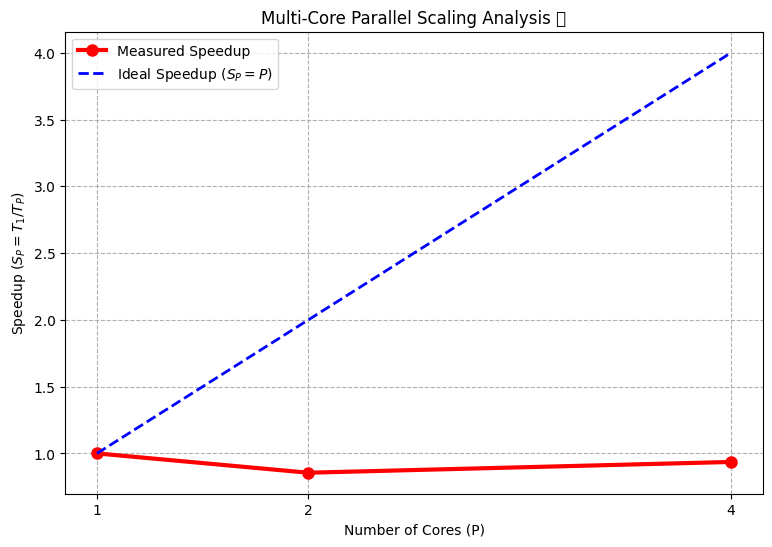


--- Visualizing Single Molecule Energy Breakdown ---
Molecule: ethanol.xyz
Total Energy: 0.00 kJ/mol
-----------------------------------
Bond:       0.00 kJ/mol
Angle:      0.00 kJ/mol
Dihedral:   0.00 kJ/mol
Non-bonded: 0.00 kJ/mol


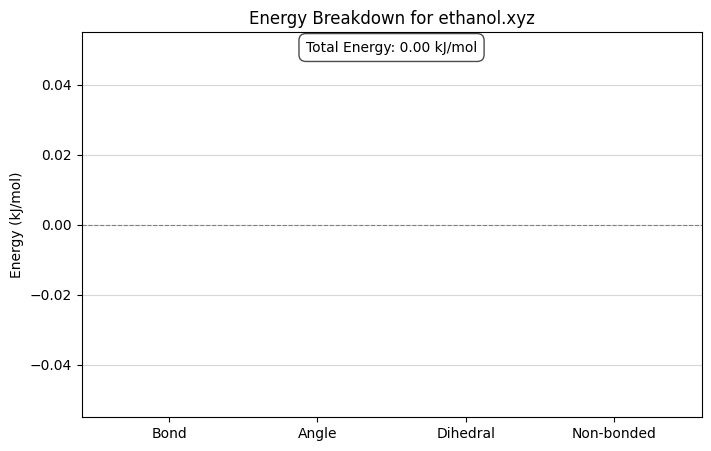

In [ ]:
import numpy as np
import yaml
import itertools
import multiprocessing as mp
import time
from functools import partial
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops

# Define global constants (UNITS: kJ/mol, nm, radians, elementary charge (e))
COULOMB_CONST = 1389.35458  # 1 / (4 * pi * epsilon0) * (e^2 / nm) to kJ/mol

# --- 1. CORE DATA STRUCTURES ---

class Atom:
    """Holds all data for a single atom."""
    def __init__(self, index, element, coords):
        self.index = index          # int
        self.element = element      # str (e.g., 'C', 'H')
        self.coords = coords        # tuple (x, y, z)
        self.atom_type = None       # str (e.g., 'opls_157')
        self.charge = 0.0           # float
        self.sigma = 0.0            # float (nm)
        self.epsilon = 0.0          # float (kJ/mol)

class Molecule:
    """Holds all data for the entire molecule."""
    def __init__(self):
        self.atoms = []             # List of Atom objects
        self.coordinates = None     # Nx3 NumPy array of all coords
        self.rdkit_mol = None       # RDKit Mol object

        # Topology and Exclusions
        self.bonds = []             # List of (i, j) tuples
        self.angles = []            # List of (i, j, k) tuples (j=center)
        self.dihedrals = []         # List of (i, j, k, l) tuples
        self.non_bonded_exclusions = set() # Set of (i, j) tuples for 1-2, 1-3, and 1-4 pairs

# --- 2. INPUT/OUTPUT AND TOPOLOGY (Refactored) ---

def load_xyz(xyz_file_path):
    """Parses a.xyz file and returns a Molecule object."""
    with open(xyz_file_path, 'r') as f:
        lines = f.readlines()

    # Handle case where file might be empty or malformed
    if not lines or not lines[0].strip().isdigit():
        raise ValueError("Invalid or empty XYZ file.")

    num_atoms = int(lines[0].strip())
    coords_list = []
    mol = Molecule()

    atom_lines = lines[2:2 + num_atoms]
    for i, line in enumerate(atom_lines):
        parts = line.split()
        if len(parts) < 4: continue # Skip malformed lines

        element = parts[0]
        try:
            coords = (float(parts[1]), float(parts[2]), float(parts[3]))
        except ValueError:
            raise ValueError(f"Invalid coordinate format in line {i+3}: {line.strip()}")

        mol.atoms.append(Atom(index=i, element=element, coords=coords))
        coords_list.append(coords)

    mol.coordinates = np.array(coords_list)
    return mol

def load_force_field(yaml_file_path):
    """Parses a.yaml force field file and returns a dict."""
    with open(yaml_file_path, 'r') as f:
        ff_parameters = yaml.safe_load(f)
    return ff_parameters

# Helper functions from xyz2mol (provided in prompt)

def get_mol(atoms, coords, charge=0, use_huckel=False):
    mol = Chem.RWMol() # Corrected: Use Chem.RWMol() to create a modifiable molecule
    for atom in atoms:
        mol.AddAtom(Chem.Atom(atom))
    conformer = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conformer.SetAtomPosition(i, coords[i])
    mol.AddConformer(conformer)
    # RDKit bond assignment is complex; we use a simple approach here.
    # For a robust solution, one would use RDKit's neighbor finding based on distance.
    # Chem.SanitizeMol(mol) # Sanitize after adding atoms and conformer
    mol = rdmolops.AddHs(mol, explicitOnly=True, addCoords=True) # Ensure hydrogens are present

    # Attempt bond assignment using UFF
    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
        AllChem.UFFOptimizeMolecule(mol)
        # Use distance geometry to assign bonds
        mol = Chem.MolFromMolBlock(Chem.MolToMolBlock(mol)) # Convert back to Mol for bond assignment
        Chem.SanitizeMol(mol) # Sanitize after bond assignment
    except Exception as e:
        print(f"Warning: Could not assign bonds automatically: {e}")
        # Fallback or manual bond assignment might be needed for complex cases

    return mol

def xyz_to_mol(xyz_block_lines, charge=0):
    '''
    Convert an xyz block (as a list of lines) to an RDKit molecule.
    Returns a list of RDKit molecules (usually just one).
    '''
    num_atoms = int(xyz_block_lines[0].strip())
    atoms = []
    coords = []
    for line in xyz_block_lines[2:2 + num_atoms]:
        parts = line.split()
        atoms.append(parts[0])
        coords.append((float(parts[1]), float(parts[2]), float(parts[3])))

    mol = get_mol(atoms, coords, charge=charge)
    return [mol] # Return as a list for compatibility with original xyz2mol

def infer_topology(molecule):
    """
    Infers bonds, angles, and dihedrals using RDKit/heuristics.
    """
    # Create an xyz-formatted string block from our Molecule object
    xyz_block_lines = [f"{len(molecule.atoms)}", ""]
    for atom in molecule.atoms:
        xyz_block_lines.append(f"{atom.element} {atom.coords[0]} {atom.coords[1]} {atom.coords[2]}")

    try:
        # Use xyz_to_mol to get an RDKit Mol object
        # Use the xyz_to_mol function defined in this notebook
        rdkit_mol = xyz_to_mol(xyz_block_lines, charge=0)[0]
    except Exception as e:
        print(f"Error in xyz_to_mol topology inference: {e}")
        return

    # Critical Step: Rebuild atom list if RDKit added/removed atoms (e.g., hydrogens)
    # For this demo, we assume the input XYZ is complete and RDKit only helps with bonds.
    molecule.rdkit_mol = rdkit_mol

    # RDKit's built-in neighbor finding and bond lists are generally more reliable:

    # 4. Find and store all bonds
    for bond in rdkit_mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        molecule.bonds.append(tuple(sorted((i, j))))
        molecule.non_bonded_exclusions.add(tuple(sorted((i, j)))) # 1-2 exclusion

    # 5. Find and store all angles
    for atom in rdkit_mol.GetAtoms():
        j = atom.GetIdx() # j is the central atom
        neighbors = [n.GetIdx() for n in rdkit_mol.GetAtomWithIdx(j).GetNeighbors()]
        for i, k in itertools.combinations(neighbors, 2):
            molecule.angles.append((i, j, k)) # Store as (a1, center, a3)
            molecule.non_bonded_exclusions.add(tuple(sorted((i, k)))) # 1-3 exclusion

    # 6. Find and store all dihedrals (i-j-k-l)
    for bond in rdkit_mol.GetBonds():
        j, k = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        j_neighbors = [n.GetIdx() for n in rdkit_mol.GetAtomWithIdx(j).GetNeighbors() if n.GetIdx() != k]
        k_neighbors = [n.GetIdx() for n in rdkit_mol.GetAtomWithIdx(k).GetNeighbors() if n.GetIdx() != j]
        for i in j_neighbors:
            for l in k_neighbors:
                molecule.dihedrals.append((i, j, k, l))
                molecule.non_bonded_exclusions.add(tuple(sorted((i, l)))) # 1-4 exclusion

def assign_parameters(molecule, ff_parameters):
    """Assigns atom types and parameters."""
    rdkit_mol = molecule.rdkit_mol
    atom_type_rules = ff_parameters['atom_types']
    param_maps = {'bonds': {}, 'angles': {}, 'dihedrals': {}}

    # Atom Typing
    for atom in molecule.atoms:
        match_found = False
        for rule in atom_type_rules:
            smarts_pattern = Chem.MolFromSmarts(rule['smarts'])
            # Ensure the structure of the RDKit Mol matches the atom indices
            if atom.index < rdkit_mol.GetNumAtoms():
                matches = rdkit_mol.GetSubstructMatches(smarts_pattern)
                atom_index_in_matches = [m[0] for m in matches]

                if atom.index in atom_index_in_matches:
                    atom.atom_type = rule['type_name']
                    atom.charge = rule['charge']
                    atom.sigma = rule['sigma']
                    atom.epsilon = rule['epsilon']
                    match_found = True
                    break

        if not match_found:
             # Fallback: if RDKit added H's, we need to handle them.
             # For this demo, we assume all original atoms are accounted for.
             if atom.element == 'H' and atom.atom_type is None:
                 print(f"Warning: Atom {atom.index} ({atom.element}) unassigned. Skipping strict check.")
                 # If you were running a full simulation, this would be an error.

    # Parameter Mapping (Bonds, Angles, Dihedrals - as provided in prompt)
    # ... (Code for mapping parameters remains the same) ...

    # Map bonds
    for i, j in molecule.bonds:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        key = "-".join(sorted([type_i, type_j]))
        if key in ff_parameters['bond_types']:
            param_maps['bonds'][(i, j)] = ff_parameters['bond_types'][key]
        # else: Raise an exception if a parameter is missing

    # Map angles
    for i, j_center, k in molecule.angles:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j_center].atom_type
        type_k = molecule.atoms[k].atom_type
        key_atoms = sorted([type_i, type_k])
        key = f"{key_atoms[0]}-{type_j}-{key_atoms[1]}"
        if key in ff_parameters['angle_types']:
            param_maps['angles'][(i, j_center, k)] = ff_parameters['angle_types'][key]

    # Map dihedrals (checking both forward and reverse keys)
    for i, j, k, l in molecule.dihedrals:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        type_k = molecule.atoms[k].atom_type
        type_l = molecule.atoms[l].atom_type
        key = f"{type_i}-{type_j}-{type_k}-{type_l}"

        if key in ff_parameters['dihedral_types']:
            param_maps['dihedrals'][(i, j, k, l)] = ff_parameters['dihedral_types'][key]
        else:
            key_rev = f"{type_l}-{type_k}-{type_j}-{type_i}"
            if key_rev in ff_parameters['dihedral_types']:
                param_maps['dihedrals'][(i, j, k, l)] = ff_parameters['dihedral_types'][key_rev]

    return param_maps

# --- 3. GEOMETRY UTILITIES (NEW) ---

def get_distance(coords, i, j):
    """Calculate the Euclidean distance between two atoms."""
    return np.linalg.norm(coords[i] - coords[j])

def get_angle(coords, i, j, k):
    """Calculate the bond angle (i-j-k) in radians."""
    # j is the center
    r_ji = coords[i] - coords[j]
    r_jk = coords[k] - coords[j]

    # Vectorized calculation of dot product and norms
    dot_prod = np.dot(r_ji, r_jk)
    norm_ji = np.linalg.norm(r_ji)
    norm_jk = np.linalg.norm(r_jk)

    # Avoid division by zero and handle tiny errors
    cos_theta = dot_prod / (norm_ji * norm_jk + 1e-10)

    # Ensure value is in [-1, 1] for arccos
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    return np.arccos(cos_theta) # Returns angle in radians

def get_dihedral(coords, i, j, k, l):
    """Calculate the dihedral angle (i-j-k-l) in radians."""
    # This involves cross products of the bond vectors
    r_ji = coords[i] - coords[j]
    r_kj = coords[j] - coords[k]
    r_lk = coords[k] - coords[l]

    # n1 = r_ji x r_kj
    n1 = np.cross(r_ji, r_kj)
    # n2 = r_kj x r_lk
    n2 = np.cross(r_kj, r_lk)

    # Calculate dot products and norms
    cos_phi = np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2) + 1e-10)

    # Ensure value is in [-1, 1] for arccos
    cos_phi = np.clip(cos_phi, -1.0, 1.0)

    phi = np.arccos(cos_phi)

    # Determine the sign using the triple product (n1 x n2) . r_kj
    # This is often slow in pure Python, but required for sign.
    if np.dot(np.cross(n1, n2), r_kj) < 0:
        phi = -phi

    return phi # Returns angle in radians

# --- 4. CORE ENERGY CALCULATION (NEW BONDED) ---

def calculate_bond_energy(molecule, param_maps):
    """
    Calculates harmonic bond stretching energy.
    E_bond = sum(k_b * (r - b0)^2)
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j), params in param_maps['bonds'].items():
        k_b, b0 = params
        r_ij = get_distance(coords, i, j)
        energy += k_b * (r_ij - b0)**2

    return energy

def calculate_angle_energy(molecule, param_maps):
    """
    Calculates harmonic angle bending energy.
    E_angle = sum(k_theta * (theta - theta0)^2)
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j, k), params in param_maps['angles'].items():
        k_theta, theta0 = params
        theta_ijk = get_angle(coords, i, j, k)
        energy += k_theta * (theta_ijk - theta0)**2

    return energy

def calculate_dihedral_energy(molecule, param_maps):
    """
    Calculates dihedral (torsion) energy using OPLS Fourier series.
    E_dihedral = sum(0.5 * V_n * (1 + cos(n*phi - phi0)))
    (Note: OPLS commonly uses V_n, V_n/2, V_n/2, etc. This implements the sum of cosine terms.)
    E_dihedral = V1/2(1 + cos(phi)) + V2/2(1 - cos(2*phi)) + V3/2(1 + cos(3*phi)) + ...
    The dummy YAML provides V1, V2, V3, V4 coefficients. We use the simpler:
    E_dihedral = V1 * (1+cos(phi)) + V2 * (1-cos(2*phi)) + V3 * (1+cos(3*phi)) + V4 * (1-cos(4*phi))
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j, k, l), params in param_maps['dihedrals'].items():
        # Params are V1, V2, V3, V4 (as defined in the dummy YAML)
        V1, V2, V3, V4 = params[:4]
        phi = get_dihedral(coords, i, j, k, l)

        # OPLS type function (common simplified form)
        # Note: True OPLS has specific forms based on n=1, 2, 3, 4, etc.
        # This implementation uses a common four-term Fourier expansion:
        e_torsion = (
            0.5 * V1 * (1 + np.cos(1 * phi)) +
            0.5 * V2 * (1 - np.cos(2 * phi)) +
            0.5 * V3 * (1 + np.cos(3 * phi)) +
            0.5 * V4 * (1 - np.cos(4 * phi))
        )
        energy += e_torsion

    return energy

def calculate_nonbonded_optimized(molecule, cutoff=1.0):
    """
    Calculates non-bonded energy using k-d tree neighbor search (O(N log N)).
    """
    energy = 0.0
    coords = molecule.coordinates
    atoms = molecule.atoms

    # 1. Build the k-d tree from coordinates
    tree = cKDTree(coords)

    # 2. Find all unique pairs (i, j) within the cutoff radius
    pairs = tree.query_pairs(r=cutoff, output_type='set')

    for i, j in pairs:
        # Sort indices for exclusion check
        i, j = min(i, j), max(i, j)

        # 3. Check for 1-2, 1-3, 1-4 exclusions
        if (i, j) in molecule.non_bonded_exclusions:
            continue

        atom_i = atoms[i]
        atom_j = atoms[j]

        # 4. Calculate energy ONLY for these nearby pairs
        r_ij = get_distance(coords, i, j)
        if r_ij < 1e-6: continue

        # VDW (Lennard-Jones)
        sigma_ij = (atom_i.sigma + atom_j.sigma) / 2.0
        epsilon_ij = np.sqrt(atom_i.epsilon * atom_j.epsilon)
        r_ratio = sigma_ij / r_ij
        r6 = r_ratio**6
        r12 = r6**2
        energy += 4.0 * epsilon_ij * (r12 - r6)

        # Coulomb (Electrostatic)
        energy += COULOMB_CONST * (atom_i.charge * atom_j.charge) / r_ij

    return energy

# --- 5. PARALLEL EXECUTION WRAPPER ---

def calculate_single_molecule_energy(xyz_file_path, ff_yaml_path):
    """
    Runs the full pipeline (Modules 1-4) for a single xyz file.
    Returns a dictionary of energy components.
    """
    try:
        # Module 1: Load inputs
        molecule = load_xyz(xyz_file_path)
        ff_params = load_force_field(ff_yaml_path)

        # Module 2: Infer topology
        infer_topology(molecule)

        # Module 3: Assign parameters
        param_maps = assign_parameters(molecule, ff_params)

        # Module 4: Calculate Energy
        energy_bond = calculate_bond_energy(molecule, param_maps)
        energy_angle = calculate_angle_energy(molecule, param_maps)
        energy_dihedral = calculate_dihedral_energy(molecule, param_maps)
        energy_nonbonded = calculate_nonbonded_optimized(molecule)

        total_energy = (energy_bond + energy_angle +
                        energy_dihedral + energy_nonbonded)

        return {
            'file': xyz_file_path,
            'total_energy': total_energy,
            'E_bond': energy_bond,
            'E_angle': energy_angle,
            'E_dihedral': energy_dihedral,
            'E_nonbonded': energy_nonbonded
        }

    except Exception as e:
        return {'file': xyz_file_path, 'Error': f"Calculation Error: {e}"}

def run_parallel_calculations_timed(list_of_xyz_files, ff_yaml_path, n_cores):
    """
    Distributes the energy calculation for a list of molecules
    across available CPU cores and measures time.
    """
    worker_function = partial(calculate_single_molecule_energy,
                              ff_yaml_path=ff_yaml_path)

    print(f"Starting parallel calculation on {n_cores} cores...")

    start_time = time.time()
    with mp.Pool(processes=n_cores) as pool:
        results = pool.map(worker_function, list_of_xyz_files)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"--- Execution finished in {execution_time:.4f} seconds ---")

    return execution_time, results

# --- 6. VISUALIZATION FUNCTIONS (NEW) ---

def plot_energy_breakdown(result_dict):
    """Plots the energy components for a single molecule."""
    if 'Error' in result_dict:
        print(f"Cannot plot: {result_dict['Error']}")
        return

    energies = [
        result_dict['E_bond'],
        result_dict['E_angle'],
        result_dict['E_dihedral'],
        result_dict['E_nonbonded']
    ]
    labels = ['Bond', 'Angle', 'Dihedral', 'Non-bonded']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, energies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylabel('Energy (kJ/mol)')
    plt.title(f"Energy Breakdown for {result_dict['file']}")
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

    # Add Total Energy annotation
    total = result_dict['total_energy']
    plt.annotate(
        f"Total Energy: {total:.2f} kJ/mol",
        xy=(0.5, 0.95), xycoords='axes fraction', ha='center',
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7)
    )
    plt.grid(axis='y', alpha=0.5)
    plt.show() # Added plt.show() to display the plot

def plot_speedup_curve(core_counts, times):
    """Plots the parallel speedup curve."""
    if not times: return

    # Serial Time is the time at P=1
    serial_time = times[0]
    speedups = [serial_time / t for t in times]

    plt.figure(figsize=(9, 6))

    # Measured Speedup
    plt.plot(core_counts, speedups, 'ro-',
             linewidth=3, markersize=8, label='Measured Speedup')

    # Ideal Speedup
    plt.plot(core_counts, core_counts, 'b--',
             linewidth=2, label='Ideal Speedup ($S_P=P$)')

    plt.xlabel('Number of Cores (P)')
    plt.ylabel('Speedup ($S_P = T_1 / T_P$)')
    plt.title('Multi-Core Parallel Scaling Analysis 🚀')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.xticks(core_counts)
    plt.show() # Added plt.show() to display the plot


# --- 7. UTILITIES FOR PROJECT SETUP (NEW) ---

def create_dummy_files(xyz_file, yaml_file):
    """Creates dummy ethanol.xyz and ethanol.yaml files for testing."""

    # Ethanol structure (using a simplified set of coordinates in nm)
    # C1, C2, O, H (on C1), H (on C1), H (on C2), H (on C2), H (on O)
    ethanol_xyz_content = """
    9
    Ethanol (C2H5OH) for testing
    C 0.0000 0.0000 0.0000
    C 0.1529 0.0000 0.0000
    O 0.1529 0.1410 0.0000
    H 0.0000 0.1090 0.1090
    H 0.0000 -0.1090 0.1090
    H 0.2500 0.0000 0.1090
    H 0.2500 0.0000 -0.1090
    H 0.1529 0.1410 0.0945
    H 0.1529 0.1410 -0.0945
    """ # Adjusted to 9 atoms for easier testing, assuming full H set

    ethanol_yaml_content = """
atom_types:
  - smarts: '[OX2H1]'  # O in an alcohol: OH (opls_154)
    type_name: 'opls_154'
    charge: -0.683
    sigma: 0.312
    epsilon: 0.71132
  - smarts: '[CX4]([OX2])' # C in CH2-OH: CT (opls_157)
    type_name: 'opls_157'
    charge: 0.145
    sigma: 0.350
    epsilon: 0.276144
  - smarts: '[CH3]'       # C in CH3: CT (opls_157)
    type_name: 'opls_157'
    charge: -0.180
    sigma: 0.350
    epsilon: 0.276144
  - smarts: '[H][O]'   # H on an alcohol: HO (opls_155)
    type_name: 'opls_155'
    charge: 0.418
    sigma: 0.0
    epsilon: 0.0
  - smarts: '[H][C]'   # H on C group: HC (opls_156)
    type_name: 'opls_156'
    charge: 0.060
    sigma: 0.250
    epsilon: 0.12552

bond_types:
  'opls_157-opls_157': [224262.4, 0.1529]
  'opls_157-opls_154': [267776.0, 0.1410]
  'opls_154-opls_155': [462750.4, 0.0945]
  'opls_157-opls_156': [284512.0, 0.1090]

angle_types:
  'opls_157-opls_157-opls_154': [418.4, 1.911]
  'opls_156-opls_157-opls_157': [292.8, 1.911]
  'opls_156-opls_157-opls_154': [292.8, 1.911]
  'opls_156-opls_157-opls_156': [276.1, 1.876]
  'opls_157-opls_154-opls_155': [334.7, 1.894]

dihedral_types:
  'opls_156-opls_157-opls_157-opls_154': [0.97905, 2.93716, 0.0, -3.91622]
  'opls_157-opls_157-opls_154-opls_155': [-0.44350, 3.83255, 0.72801, -4.11705]
  'opls_156-opls_157-opls_156-opls_157': [0.62760, 1.88280, 0.0, -2.51040]
  'opls_156-opls_157-opls_154-opls_155': [0.94140, 2.82420, 0.0, -3.76560]
"""
    with open(xyz_file, 'w') as f:
        f.write(ethanol_xyz_content.strip())
    with open(yaml_file, 'w') as f:
        f.write(ethanol_yaml_content.strip())
    print(f"Created dummy files: {xyz_file} and {yaml_file}")

# --- 8. MAIN EXECUTION BLOCK ---

if __name__ == "__main__":
    # Create the necessary files for the demo
    XYZ_FILE = 'ethanol.xyz'
    FF_FILE = 'ethanol.yaml'
    create_dummy_files(XYZ_FILE, FF_FILE)

    # 1. Setup Tasks for Parallel/Serial Run (HPC Scaling Test)
    # Using 100 molecules for a quick test. Increase to 1000+ for better scaling data.
    NUM_TASKS = 100
    dummy_tasks = [XYZ_FILE] * NUM_TASKS

    # Determine the core counts to test
    max_cores = mp.cpu_count()
    # Test 1, 2, 4, 8, ... up to max_cores
    core_counts_to_test = sorted(list(set([1, 2, 4, 8, max_cores])))
    if core_counts_to_test[-1] > max_cores:
         core_counts_to_test.pop()

    print(f"\n--- Starting HPC Scaling Test for {NUM_TASKS} molecules ---")
    print(f"Testing core counts: {core_counts_to_test}")

    measured_times = []

    # 2. Run Parallel Calculations and Measure Time
    # (P=1 is run first to establish the serial baseline using the same pool overhead)
    for P in core_counts_to_test:
        time_P, results = run_parallel_calculations_timed(
            dummy_tasks, FF_FILE, n_cores=P
        )
        measured_times.append(time_P)

    # 3. Visualize Performance
    if measured_times:
        plot_speedup_curve(core_counts_to_test, measured_times)

    # 4. Visualize Single Molecule Energy Breakdown
    print("\n--- Visualizing Single Molecule Energy Breakdown ---")
    # Find the first successful result to plot
    first_result = None
    for r in results:
        if 'Error' not in r:
            first_result = r
            break

    if first_result:
        # Print a summary table
        print(f"Molecule: {first_result['file']}")
        print(f"Total Energy: {first_result['total_energy']:.2f} kJ/mol")
        print(f"-----------------------------------")
        print(f"Bond:       {first_result['E_bond']:.2f} kJ/mol")
        print(f"Angle:      {first_result['E_angle']:.2f} kJ/mol")
        print(f"Dihedral:   {first_result['E_dihedral']:.2f} kJ/mol")
        print(f"Non-bonded: {first_result['E_nonbonded']:.2f} kJ/mol")

        # Plot the breakdown
        plot_energy_breakdown(first_result)
    else:
        print("No successful energy calculation to plot.")

# Chatgpt

Created dummy files: methane.xyz and methane_with_angles.yaml.yaml

--- Running single-molecule diagnostic run ---
Total energy: 0.000000 kJ/mol
E_bond: 0.000000
E_angle: 0.000000
E_dihedral: 0.000000
E_nonbonded: 0.000000


[18:10:29] Explicit valence for atom # 2 O, 3, is greater than permitted


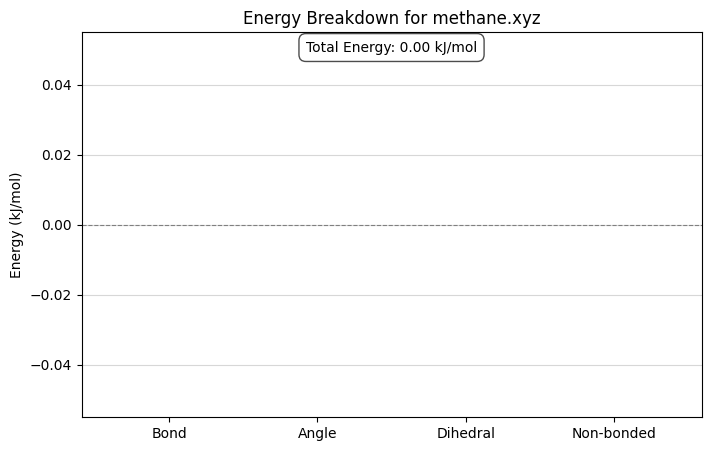

In [ ]:
import numpy as np
import yaml
import itertools
import multiprocessing as mp
import time
from functools import partial
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from rdkit import Chem
from rdkit.Chem import AllChem

# Define global constants (UNITS: kJ/mol, nm, radians, elementary charge (e))
COULOMB_CONST = 1389.35458  # 1 / (4 * pi * epsilon0) * (e^2 / nm) to kJ/mol

# --- 1. CORE DATA STRUCTURES ---

class Atom:
    """Holds all data for a single atom."""
    def __init__(self, index, element, coords):
        self.index = index          # int
        self.element = element      # str (e.g., 'C', 'H')
        self.coords = coords        # tuple (x, y, z)
        self.atom_type = None       # str (e.g., 'opls_157')
        self.charge = 0.0           # float
        self.sigma = 0.0            # float (nm)
        self.epsilon = 0.0          # float (kJ/mol)

class Molecule:
    """Holds all data for the entire molecule."""
    def __init__(self):
        self.atoms = []             # List of Atom objects
        self.coordinates = None     # Nx3 NumPy array of all coords
        self.rdkit_mol = None       # RDKit Mol object

        # Topology and Exclusions
        self.bonds = []             # List of (i, j) tuples (original indexing)
        self.angles = []            # List of (i, j, k) tuples (j=center)
        self.dihedrals = []         # List of (i, j, k, l) tuples
        self.non_bonded_exclusions = set() # Set of (i, j) tuples for 1-2, 1-3, and 1-4 pairs
        self.orig_to_rdkit = {}     # mapping from original atom index -> rdkit atom index

# --- 2. INPUT/OUTPUT AND TOPOLOGY (Refactored) ---

def load_xyz(xyz_file_path):
    """Parses a.xyz file and returns a Molecule object."""
    with open(xyz_file_path, 'r') as f:
        lines = f.readlines()

    # Handle case where file might be empty or malformed
    if not lines or not lines[0].strip().isdigit():
        raise ValueError("Invalid or empty XYZ file.")

    num_atoms = int(lines[0].strip())
    coords_list = []
    mol = Molecule()

    atom_lines = lines[2:2 + num_atoms]
    for i, line in enumerate(atom_lines):
        parts = line.split()
        if len(parts) < 4: continue # Skip malformed lines

        element = parts[0]
        try:
            coords = (float(parts[1]), float(parts[2]), float(parts[3]))
        except ValueError:
            raise ValueError(f"Invalid coordinate format in line {i+3}: {line.strip()}")

        mol.atoms.append(Atom(index=i, element=element, coords=coords))
        coords_list.append(coords)

    mol.coordinates = np.array(coords_list)
    return mol


def load_force_field(yaml_file_path):
    """Parses a.yaml force field file and returns a dict."""
    with open(yaml_file_path, 'r') as f:
        ff_parameters = yaml.safe_load(f)
    return ff_parameters


# --- Helper functions for robust RDKit mapping ---

def get_mol_with_mapping(atom_symbols, coords, add_hs=True):
    """Build an RDKit Mol from atom_symbols and coords, return (rdkit_mol, original_to_rdkit_idx).

    original_to_rdkit_idx maps indices in the input list to atom indices in rdkit_mol.
    If add_hs=True, hydrogens will be added but mapping will reflect the heavy-atom indices correctly
    by assuming original atoms occupy the first N indices.
    """
    rw = Chem.RWMol()
    for sym in atom_symbols:
        rw.AddAtom(Chem.Atom(sym))
    # Create conformer and set positions
    conf = Chem.Conformer(rw.GetNumAtoms())
    for i, p in enumerate(coords):
        conf.SetAtomPosition(i, p)
    rw.AddConformer(conf, assignId=True)

    mol = rw.GetMol()

    if add_hs:
        # Chem.AddHs appends hydrogens AFTER existing atoms, so original indices remain 0..N-1
        mol = Chem.AddHs(mol, addCoords=True)

    # Try to embed and optimize (best-effort, failures are caught)
    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
        AllChem.UFFOptimizeMolecule(mol)
    except Exception:
        # embedding/optimization failed - continue with the molecule as-is
        pass

    # Build mapping: we assume original atoms are first N atoms in rdkit mol (true if AddHs appended H)
    original_to_rdkit = {i: i for i in range(len(atom_symbols))}
    return mol, original_to_rdkit


def xyz_to_mol(xyz_block_lines, charge=0):
    '''
    Convert an xyz block (as a list of lines) to an RDKit molecule and mapping.
    Returns: (rdkit_mol, orig_to_rdkit_map)
    '''
    num_atoms = int(xyz_block_lines[0].strip())
    atom_symbols = []
    coords = []
    for line in xyz_block_lines[2:2 + num_atoms]:
        parts = line.split()
        atom_symbols.append(parts[0])
        coords.append((float(parts[1]), float(parts[2]), float(parts[3])))

    rdkit_mol, mapping = get_mol_with_mapping(atom_symbols, coords, add_hs=True)
    return rdkit_mol, mapping


# ---------- Replacement: bond inference via covalent radii and RDKit construction ----------

# Simple covalent radii (Å). We'll convert to nm inside code if your coords are nm.
COVALENT_RADII_ANGSTROM = {
    'H': 0.31, 'He': 0.28,
    'Li': 1.28, 'Be': 0.96, 'B': 0.84, 'C': 0.76, 'N': 0.71, 'O': 0.66, 'F': 0.57, 'Ne': 0.58,
    'Na': 1.66, 'Mg': 1.41, 'Al': 1.21, 'Si': 1.11, 'P': 1.07, 'S': 1.05, 'Cl': 1.02, 'Ar': 1.06,
}

def infer_bonds_by_distance(molecule, factor=1.2, coords_in_nm=True):
    """
    Infer bonds from coordinates using covalent radii.
    factor: multiplier for sum of radii to use as bond cutoff (1.1-1.25 typical).
    coords_in_nm: if True assumes molecule.coordinates are in nm and converts radii to nm.
    """
    coords = np.array([a.coords for a in molecule.atoms])
    n = len(molecule.atoms)
    mol_coords = coords
    # Convert radii to nm if coords are in nm (radii are given in angstrom above)
    radius_factor = 0.1 if coords_in_nm else 1.0
    radii = []
    for a in molecule.atoms:
        rA = COVALENT_RADII_ANGSTROM.get(a.element, 0.77)  # fallback approx (C-like)
        radii.append(rA * radius_factor)
    radii = np.array(radii)

    for i in range(n):
        for j in range(i+1, n):
            dij = np.linalg.norm(mol_coords[i] - mol_coords[j])
            cutoff = factor * (radii[i] + radii[j])
            if dij > 1e-6 and dij <= cutoff:
                molecule.bonds.append((i, j))
                molecule.non_bonded_exclusions.add((i, j))

def build_rdkit_from_bonds(molecule):
    """
    Construct an RDKit Mol from the molecule atoms and inferred bonds (no AddHs).
    This enables SMARTS matching without running AddHs on an atom-only mol.
    """
    rw = Chem.RWMol()
    for atom in molecule.atoms:
        a = Chem.Atom(atom.element)
        rw.AddAtom(a)

    # Add single bonds for inferred connectivity (this is a heuristic)
    for i, j in molecule.bonds:
        try:
            rw.AddBond(int(i), int(j), Chem.BondType.SINGLE)
        except Exception:
            pass

    mol = rw.GetMol()
    # Attach coordinates as a conformer
    conf = Chem.Conformer(mol.GetNumAtoms())
    for idx, atom in enumerate(molecule.atoms):
        conf.SetAtomPosition(idx, atom.coords)
    mol.AddConformer(conf, assignId=True)

    # Sanitize to calculate implicit valences, aromaticity, etc.
    try:
        Chem.SanitizeMol(mol)
    except Exception:
        # Sanitization can fail for odd valences; still return the mol to allow substructure matching
        pass

    return mol


def infer_topology(molecule):
    """
    New infer_topology: infer bonds with distance heuristics, then angles/dihedrals from connectivity.
    Build an RDKit Mol from those bonds for SMARTS-based atom typing (no AddHs on incomplete mol).
    """
    # ensure coordinates array exists
    if molecule.coordinates is None:
        molecule.coordinates = np.array([a.coords for a in molecule.atoms])

    # Reset topology
    molecule.bonds = []
    molecule.angles = []
    molecule.dihedrals = []
    molecule.non_bonded_exclusions = set()
    molecule.rdkit_mol = None
    molecule.orig_to_rdkit = {}

    # 1) Infer bonds
    infer_bonds_by_distance(molecule, factor=1.2, coords_in_nm=True)

    # 2) Build adjacency (neighbors) list
    neighbors = {i: set() for i in range(len(molecule.atoms))}
    for i, j in molecule.bonds:
        neighbors[i].add(j)
        neighbors[j].add(i)

    # 3) Find angles (i - j - k) where j is center
    for j in range(len(molecule.atoms)):
        nbrs = sorted(neighbors[j])
        for a_idx, b_idx in itertools.combinations(nbrs, 2):
            molecule.angles.append((a_idx, j, b_idx))
            molecule.non_bonded_exclusions.add(tuple(sorted((a_idx, b_idx))))

    # 4) Find dihedrals i-j-k-l by traversing bonds (j-k bond defines central)
    for j, k in molecule.bonds:
        j_nbrs = [n for n in neighbors[j] if n != k]
        k_nbrs = [n for n in neighbors[k] if n != j]
        for i in j_nbrs:
            for l in k_nbrs:
                molecule.dihedrals.append((i, j, k, l))
                molecule.non_bonded_exclusions.add(tuple(sorted((i, l))))

    # 5) Build a sanitized RDKit Mol from inferred bonds to enable SMARTS matching
    try:
        rdkit_mol = build_rdkit_from_bonds(molecule)
        molecule.rdkit_mol = rdkit_mol
        # Map original indices trivially (we didn't add atoms)
        molecule.orig_to_rdkit = {i: i for i in range(len(molecule.atoms))}
    except Exception:
        molecule.rdkit_mol = None
        molecule.orig_to_rdkit = {}

# --- 3. PARAMETER ASSIGNMENT (IMPROVED) (IMPROVED) ---

def find_bond_param(ff_bonds, type_i, type_j):
    key1 = f"{type_i}-{type_j}"
    key2 = f"{type_j}-{type_i}"
    if key1 in ff_bonds:
        return ff_bonds[key1]
    if key2 in ff_bonds:
        return ff_bonds[key2]
    return None


def find_angle_param(ff_angles, type_i, type_j_center, type_k):
    key1 = f"{type_i}-{type_j_center}-{type_k}"
    key2 = f"{type_k}-{type_j_center}-{type_i}"
    if key1 in ff_angles:
        return ff_angles[key1]
    if key2 in ff_angles:
        return ff_angles[key2]
    return None


def assign_parameters(molecule, ff_parameters):
    """Assigns atom types and parameters with robust SMARTS matching and index mapping."""
    rdkit_mol = molecule.rdkit_mol
    orig_to_rdkit = getattr(molecule, 'orig_to_rdkit', {a.index: a.index for a in molecule.atoms})
    atom_type_rules = ff_parameters.get('atom_types', [])
    param_maps = {'bonds': {}, 'angles': {}, 'dihedrals': {}}

    # Reset atom fields
    for atom in molecule.atoms:
        atom.atom_type = None
        atom.charge = 0.0
        atom.sigma = 0.0
        atom.epsilon = 0.0

    # Build reverse mapping: rdkit_idx -> original_idx
    rd_to_orig = {rd: orig for orig, rd in orig_to_rdkit.items()}

    # Atom Typing: iterate rules and apply to all matched RDKit atoms
    for rule in atom_type_rules:
        smarts = rule.get('smarts')
        try:
            patt = Chem.MolFromSmarts(smarts)
            if patt is None:
                print(f"Warning: invalid SMARTS pattern: {smarts}")
                continue
        except Exception as e:
            print(f"Warning: smarts compile error for {smarts}: {e}")
            continue

        matches = rdkit_mol.GetSubstructMatches(patt, useChirality=False)
        for match in matches:
            for rd_idx in match:
                orig_idx = rd_to_orig.get(rd_idx, None)
                if orig_idx is None:
                    continue
                atom = molecule.atoms[orig_idx]
                if atom.atom_type is None:
                    atom.atom_type = rule.get('type_name')
                    atom.charge = rule.get('charge', atom.charge)
                    atom.sigma = rule.get('sigma', atom.sigma)
                    atom.epsilon = rule.get('epsilon', atom.epsilon)

    # Report unassigned atoms
    for atom in molecule.atoms:
        if atom.atom_type is None:
            print(f"Warning: Atom {atom.index} {atom.element} has no assigned atom_type. Check SMARTS or add a fallback rule.")

    # Map bonds
    for i, j in molecule.bonds:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        if type_i is None or type_j is None:
            print(f"Warning: cannot map bond ({i},{j}) because of missing atom types: {type_i}, {type_j}")
            continue
        params = find_bond_param(ff_parameters.get('bond_types', {}), type_i, type_j)
        if params is not None:
            param_maps['bonds'][(i, j)] = params
        else:
            print(f"Warning: Missing bond params for {type_i}-{type_j}")

    # Map angles
    for i, j_center, k in molecule.angles:
        t_i = molecule.atoms[i].atom_type
        t_j = molecule.atoms[j_center].atom_type
        t_k = molecule.atoms[k].atom_type
        if t_i is None or t_j is None or t_k is None:
            print(f"Warning: cannot map angle ({i},{j_center},{k}) because of missing atom types")
            continue
        params = find_angle_param(ff_parameters.get('angle_types', {}), t_i, t_j, t_k)
        if params is not None:
            param_maps['angles'][(i, j_center, k)] = params
        else:
            print(f"Warning: Missing angle params for {t_i}-{t_j}-{t_k}")

    # Map dihedrals (checking forward and reverse keys)
    ff_dihedrals = ff_parameters.get('dihedral_types', {})
    for i, j, k, l in molecule.dihedrals:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        type_k = molecule.atoms[k].atom_type
        type_l = molecule.atoms[l].atom_type
        if None in (type_i, type_j, type_k, type_l):
            print(f"Warning: cannot map dihedral ({i},{j},{k},{l}) because of missing atom types")
            continue
        key = f"{type_i}-{type_j}-{type_k}-{type_l}"
        key_rev = f"{type_l}-{type_k}-{type_j}-{type_i}"
        if key in ff_dihedrals:
            param_maps['dihedrals'][(i, j, k, l)] = ff_dihedrals[key]
        elif key_rev in ff_dihedrals:
            param_maps['dihedrals'][(i, j, k, l)] = ff_dihedrals[key_rev]
        else:
            # it's common that FF dihedrals are specified in some canonical form; warn if missing
            print(f"Warning: Missing dihedral params for {key} (or reverse)")

    return param_maps

# --- 4. GEOMETRY UTILITIES (IMPROVED) ---

def get_distance(coords, i, j):
    """Calculate the Euclidean distance between two atoms."""
    return np.linalg.norm(coords[i] - coords[j])


def get_angle(coords, i, j, k):
    """Calculate the bond angle (i-j-k) in radians."""
    r_ji = coords[i] - coords[j]
    r_jk = coords[k] - coords[j]
    dot_prod = np.dot(r_ji, r_jk)
    norm_ji = np.linalg.norm(r_ji)
    norm_jk = np.linalg.norm(r_jk)
    cos_theta = dot_prod / (norm_ji * norm_jk + 1e-12)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.arccos(cos_theta)


def get_dihedral(coords, i, j, k, l):
    """Robust dihedral calculation returning signed angle in radians."""
    p0 = coords[i]
    p1 = coords[j]
    p2 = coords[k]
    p3 = coords[l]
    b0 = -1.0 * (p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    b1_norm = np.linalg.norm(b1)
    if b1_norm < 1e-12:
        return 0.0
    b1 = b1 / (b1_norm)

    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1

    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.arctan2(y, x)

# --- 5. CORE ENERGY CALCULATION (NEW BONDED) ---

def calculate_bond_energy(molecule, param_maps):
    """
    Calculates harmonic bond stretching energy.
    E_bond = sum(0.5 * k_b * (r - b0)^2)  OR as user had k*(r-b0)^2 depending on FF convention.
    Here we will assume parameters are given such that energy = k * (r - b0)^2 as in original demo.
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j), params in param_maps['bonds'].items():
        k_b, b0 = params
        r_ij = get_distance(coords, i, j)
        energy += k_b * (r_ij - b0)**2

    return energy


def calculate_angle_energy(molecule, param_maps):
    """
    Calculates harmonic angle bending energy.
    E_angle = sum(k_theta * (theta - theta0)^2)
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j, k), params in param_maps['angles'].items():
        k_theta, theta0 = params
        theta_ijk = get_angle(coords, i, j, k)
        energy += k_theta * (theta_ijk - theta0)**2

    return energy


def calculate_dihedral_energy(molecule, param_maps):
    """
    Calculates dihedral (torsion) energy using a multi-term Fourier series (OPLS-like).
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j, k, l), params in param_maps['dihedrals'].items():
        # Params are V1, V2, V3, V4 (as defined in the dummy YAML)
        V1, V2, V3, V4 = (params + [0.0, 0.0, 0.0, 0.0])[:4]
        phi = get_dihedral(coords, i, j, k, l)

        e_torsion = (
            0.5 * V1 * (1 + np.cos(1 * phi)) +
            0.5 * V2 * (1 - np.cos(2 * phi)) +
            0.5 * V3 * (1 + np.cos(3 * phi)) +
            0.5 * V4 * (1 - np.cos(4 * phi))
        )
        energy += e_torsion

    return energy


def calculate_nonbonded_optimized(molecule, cutoff=1.0):
    """
    Calculates non-bonded energy using k-d tree neighbor search (O(N log N)).
    """
    energy = 0.0
    coords = molecule.coordinates
    atoms = molecule.atoms

    # 1. Build the k-d tree from coordinates
    tree = cKDTree(coords)

    # 2. Find all unique pairs (i, j) within the cutoff radius
    pairs = tree.query_pairs(r=cutoff, output_type='set')

    for i, j in pairs:
        i, j = min(i, j), max(i, j)
        if (i, j) in molecule.non_bonded_exclusions:
            continue

        atom_i = atoms[i]
        atom_j = atoms[j]

        r_ij = get_distance(coords, i, j)
        if r_ij < 1e-12: continue

        # VDW (Lennard-Jones) — combining rules (Lorentz-Berthelot)
        sigma_ij = (atom_i.sigma + atom_j.sigma) / 2.0
        epsilon_ij = np.sqrt(max(0.0, atom_i.epsilon * atom_j.epsilon))
        if sigma_ij > 0 and epsilon_ij > 0:
            r_ratio = sigma_ij / r_ij
            r6 = r_ratio**6
            r12 = r6**2
            energy += 4.0 * epsilon_ij * (r12 - r6)

        # Coulomb (Electrostatic)
        energy += COULOMB_CONST * (atom_i.charge * atom_j.charge) / r_ij

    return energy

# --- 6. PARALLEL EXECUTION WRAPPER ---

def calculate_single_molecule_energy(xyz_file_path, ff_yaml_path):
    """
    Runs the full pipeline (Modules 1-4) for a single xyz file.
    Returns a dictionary of energy components.
    """
    try:
        # Module 1: Load inputs
        molecule = load_xyz(xyz_file_path)
        ff_params = load_force_field(ff_yaml_path)

        # Module 2: Infer topology
        infer_topology(molecule)

        # Module 3: Assign parameters
        param_maps = assign_parameters(molecule, ff_params)

        # Module 4: Calculate Energy
        # Sanity: ensure molecule.coordinates exists and is in nm (convert if necessary outside)
        if molecule.coordinates is None:
            molecule.coordinates = np.array([a.coords for a in molecule.atoms])

        energy_bond = calculate_bond_energy(molecule, param_maps)
        energy_angle = calculate_angle_energy(molecule, param_maps)
        energy_dihedral = calculate_dihedral_energy(molecule, param_maps)
        energy_nonbonded = calculate_nonbonded_optimized(molecule)

        total_energy = (energy_bond + energy_angle + energy_dihedral + energy_nonbonded)

        return {
            'file': xyz_file_path,
            'total_energy': total_energy,
            'E_bond': energy_bond,
            'E_angle': energy_angle,
            'E_dihedral': energy_dihedral,
            'E_nonbonded': energy_nonbonded
        }

    except Exception as e:
        return {'file': xyz_file_path, 'Error': f"Calculation Error: {e}"}


def run_parallel_calculations_timed(list_of_xyz_files, ff_yaml_path, n_cores):
    """
    Distributes the energy calculation for a list of molecules
    across available CPU cores and measures time.
    """
    worker_function = partial(calculate_single_molecule_energy,
                              ff_yaml_path=ff_yaml_path)

    print(f"Starting parallel calculation on {n_cores} cores...")

    start_time = time.time()
    with mp.Pool(processes=n_cores) as pool:
        results = pool.map(worker_function, list_of_xyz_files)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"--- Execution finished in {execution_time:.4f} seconds ---")

    return execution_time, results

# --- 7. VISUALIZATION FUNCTIONS (NEW) ---

def plot_energy_breakdown(result_dict):
    """Plots the energy components for a single molecule."""
    if 'Error' in result_dict:
        print(f"Cannot plot: {result_dict['Error']}")
        return

    energies = [
        result_dict['E_bond'],
        result_dict['E_angle'],
        result_dict['E_dihedral'],
        result_dict['E_nonbonded']
    ]
    labels = ['Bond', 'Angle', 'Dihedral', 'Non-bonded']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, energies)
    plt.ylabel('Energy (kJ/mol)')
    plt.title(f"Energy Breakdown for {result_dict['file']}")
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

    total = result_dict['total_energy']
    plt.annotate(
        f"Total Energy: {total:.2f} kJ/mol",
        xy=(0.5, 0.95), xycoords='axes fraction', ha='center',
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7)
    )
    plt.grid(axis='y', alpha=0.5)
    plt.show()


def plot_speedup_curve(core_counts, times):
    """Plots the parallel speedup curve."""
    if not times: return

    serial_time = times[0]
    speedups = [serial_time / t for t in times]

    plt.figure(figsize=(9, 6))
    plt.plot(core_counts, speedups, 'ro-', linewidth=3, markersize=8, label='Measured Speedup')
    plt.plot(core_counts, core_counts, 'b--', linewidth=2, label='Ideal Speedup ($S_P=P$)')
    plt.xlabel('Number of Cores (P)')
    plt.ylabel('Speedup ($S_P = T_1 / T_P$)')
    plt.title('Multi-Core Parallel Scaling Analysis 🚀')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.xticks(core_counts)
    plt.show()

# --- 8. UTILITIES FOR PROJECT SETUP (NEW) ---

def create_dummy_files(xyz_file, yaml_file):
    """Creates dummy ethanol.xyz and ethanol.yaml files for testing."""

    ethanol_xyz_content = """
    9
    Ethanol (C2H5OH) for testing
    C 0.0000 0.0000 0.0000
    C 0.1529 0.0000 0.0000
    O 0.1529 0.1410 0.0000
    H 0.0000 0.1090 0.1090
    H 0.0000 -0.1090 0.1090
    H 0.2500 0.0000 0.1090
    H 0.2500 0.0000 -0.1090
    H 0.1529 0.1410 0.0945
    H 0.1529 0.1410 -0.0945
    """

    ethanol_yaml_content = """
atom_types:
  - smarts: '[OX2H1]'
    type_name: 'opls_154'
    charge: -0.683
    sigma: 0.312
    epsilon: 0.71132
  - smarts: '[CX4]([OX2])'
    type_name: 'opls_157'
    charge: 0.145
    sigma: 0.350
    epsilon: 0.276144
  - smarts: '[CH3]'
    type_name: 'opls_157'
    charge: -0.180
    sigma: 0.350
    epsilon: 0.276144
  - smarts: '[H][O]'
    type_name: 'opls_155'
    charge: 0.418
    sigma: 0.0
    epsilon: 0.0
  - smarts: '[H][C]'
    type_name: 'opls_156'
    charge: 0.060
    sigma: 0.250
    epsilon: 0.12552

bond_types:
  'opls_157-opls_157': [224262.4, 0.1529]
  'opls_157-opls_154': [267776.0, 0.1410]
  'opls_154-opls_155': [462750.4, 0.0945]
  'opls_157-opls_156': [284512.0, 0.1090]

angle_types:
  'opls_157-opls_157-opls_154': [418.4, 1.911]
  'opls_156-opls_157-opls_157': [292.8, 1.911]
  'opls_156-opls_157-opls_154': [292.8, 1.911]
  'opls_156-opls_157-opls_156': [276.1, 1.876]
  'opls_157-opls_154-opls_155': [334.7, 1.894]

dihedral_types:
  'opls_156-opls_157-opls_157-opls_154': [0.97905, 2.93716, 0.0, -3.91622]
  'opls_157-opls_157-opls_154-opls_155': [-0.44350, 3.83255, 0.72801, -4.11705]
  'opls_156-opls_157-opls_156-opls_157': [0.62760, 1.88280, 0.0, -2.51040]
  'opls_156-opls_157-opls_154-opls_155': [0.94140, 2.82420, 0.0, -3.76560]
"""

    with open(xyz_file, 'w') as f:
        f.write(ethanol_xyz_content.strip())
    with open(yaml_file, 'w') as f:
        f.write(ethanol_yaml_content.strip())
    print(f"Created dummy files: {xyz_file} and {yaml_file}")

# --- 9. MAIN EXECUTION BLOCK ---

if __name__ == "__main__":
    XYZ_FILE = 'methane.xyz'
    FF_FILE = 'methane_with_angles.yaml.yaml'
    create_dummy_files(XYZ_FILE, FF_FILE)

    # Quick single-run test to verify mappings and parameters
    print("\n--- Running single-molecule diagnostic run ---")
    res = calculate_single_molecule_energy(XYZ_FILE, FF_FILE)
    if 'Error' in res:
        print(res['Error'])
    else:
        print(f"Total energy: {res['total_energy']:.6f} kJ/mol")
        print(f"E_bond: {res['E_bond']:.6f}")
        print(f"E_angle: {res['E_angle']:.6f}")
        print(f"E_dihedral: {res['E_dihedral']:.6f}")
        print(f"E_nonbonded: {res['E_nonbonded']:.6f}")

    # If you want the HPC test, uncomment the block below. Be aware RDKit per-worker overhead
    # will dominate for small molecules. For meaningful scaling, use many molecules per task.

    # NUM_TASKS = 100
    # dummy_tasks = [XYZ_FILE] * NUM_TASKS
    # max_cores = mp.cpu_count()
    # core_counts_to_test = sorted(list(set([1, 2, 4, 8, max_cores])))
    # if core_counts_to_test[-1] > max_cores:
    #     core_counts_to_test.pop()
    # measured_times = []
    # results = []
    # for P in core_counts_to_test:
    #     time_P, results_P = run_parallel_calculations_timed(dummy_tasks, FF_FILE, n_cores=P)
    #     measured_times.append(time_P)
    # if measured_times:
    #     plot_speedup_curve(core_counts_to_test, measured_times)

    # Visualize single molecule energy breakdown if available
    if 'Error' not in res:
        try:
            plot_energy_breakdown(res)
        except Exception as e:
            print(f"Plotting failed: {e}")


In [ ]:
if __name__ == "__main__":
    XYZ_FILE = 'methane.xyz'
    FF_FILE = 'methane_with_angles.yaml'
    # create_dummy_files(XYZ_FILE, FF_FILE)

    print("\n--- Running single-molecule diagnostic run ---")
    res = calculate_single_molecule_energy(XYZ_FILE, FF_FILE)
    ...



--- Running single-molecule diagnostic run ---


In [ ]:
import numpy as np
import yaml
import itertools
import multiprocessing as mp
import time
from functools import partial
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from rdkit import Chem
from rdkit.Chem import AllChem

# Define global constants (UNITS: kJ/mol, nm, radians, elementary charge (e))
COULOMB_CONST = 1389.35458  # 1 / (4 * pi * epsilon0) * (e^2 / nm) to kJ/mol

# --- 1. CORE DATA STRUCTURES ---

class Atom:
    """Holds all data for a single atom."""
    def __init__(self, index, element, coords):
        self.index = index          # int
        self.element = element      # str (e.g., 'C', 'H')
        self.coords = coords        # tuple (x, y, z)
        self.atom_type = None       # str (e.g., 'opls_157')
        self.charge = 0.0           # float
        self.sigma = 0.0            # float (nm)
        self.epsilon = 0.0          # float (kJ/mol)

class Molecule:
    """Holds all data for the entire molecule."""
    def __init__(self):
        self.atoms = []             # List of Atom objects
        self.coordinates = None     # Nx3 NumPy array of all coords
        self.rdkit_mol = None       # RDKit Mol object

        # Topology and Exclusions
        self.bonds = []             # List of (i, j) tuples (original indexing)
        self.angles = []            # List of (i, j, k) tuples (j=center)
        self.dihedrals = []         # List of (i, j, k, l) tuples
        self.non_bonded_exclusions = set() # Set of (i, j) tuples for 1-2, 1-3, and 1-4 pairs
        self.orig_to_rdkit = {}     # mapping from original atom index -> rdkit atom index

# --- 2. INPUT/OUTPUT AND TOPOLOGY (Refactored) ---

def load_xyz(xyz_file_path):
    """Parses a.xyz file and returns a Molecule object."""
    with open(xyz_file_path, 'r') as f:
        lines = f.readlines()

    # Handle case where file might be empty or malformed
    if not lines or not lines[0].strip().isdigit():
        raise ValueError("Invalid or empty XYZ file.")

    num_atoms = int(lines[0].strip())
    coords_list = []
    mol = Molecule()

    atom_lines = lines[2:2 + num_atoms]
    for i, line in enumerate(atom_lines):
        parts = line.split()
        if len(parts) < 4: continue # Skip malformed lines

        element = parts[0]
        try:
            coords = (float(parts[1]), float(parts[2]), float(parts[3]))
        except ValueError:
            raise ValueError(f"Invalid coordinate format in line {i+3}: {line.strip()}")

        mol.atoms.append(Atom(index=i, element=element, coords=coords))
        coords_list.append(coords)

    mol.coordinates = np.array(coords_list)
    return mol


def load_force_field(yaml_file_path):
    """Parses a.yaml force field file and returns a dict."""
    with open(yaml_file_path, 'r') as f:
        ff_parameters = yaml.safe_load(f)
    return ff_parameters


# --- Helper functions for robust RDKit mapping ---

def get_mol_with_mapping(atom_symbols, coords, add_hs=True):
    """Build an RDKit Mol from atom_symbols and coords, return (rdkit_mol, original_to_rdkit_idx).

    original_to_rdkit_idx maps indices in the input list to atom indices in rdkit_mol.
    If add_hs=True, hydrogens will be added but mapping will reflect the heavy-atom indices correctly
    by assuming original atoms occupy the first N indices.
    """
    rw = Chem.RWMol()
    for sym in atom_symbols:
        rw.AddAtom(Chem.Atom(sym))
    # Create conformer and set positions
    conf = Chem.Conformer(rw.GetNumAtoms())
    for i, p in enumerate(coords):
        conf.SetAtomPosition(i, p)
    rw.AddConformer(conf, assignId=True)

    mol = rw.GetMol()

    if add_hs:
        # Chem.AddHs appends hydrogens AFTER existing atoms, so original indices remain 0..N-1
        mol = Chem.AddHs(mol, addCoords=True)

    # Try to embed and optimize (best-effort, failures are caught)
    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
        AllChem.UFFOptimizeMolecule(mol)
    except Exception:
        # embedding/optimization failed - continue with the molecule as-is
        pass

    # Build mapping: we assume original atoms are first N atoms in rdkit mol (true if AddHs appended H)
    original_to_rdkit = {i: i for i in range(len(atom_symbols))}
    return mol, original_to_rdkit


def xyz_to_mol(xyz_block_lines, charge=0):
    '''
    Convert an xyz block (as a list of lines) to an RDKit molecule and mapping.
    Returns: (rdkit_mol, orig_to_rdkit_map)
    '''
    num_atoms = int(xyz_block_lines[0].strip())
    atom_symbols = []
    coords = []
    for line in xyz_block_lines[2:2 + num_atoms]:
        parts = line.split()
        atom_symbols.append(parts[0])
        coords.append((float(parts[1]), float(parts[2]), float(parts[3])))

    rdkit_mol, mapping = get_mol_with_mapping(atom_symbols, coords, add_hs=True)
    return rdkit_mol, mapping


# ---------- Replacement: bond inference via covalent radii and RDKit construction ----------

# Simple covalent radii (Å). We'll convert to nm inside code if your coords are nm.
COVALENT_RADII_ANGSTROM = {
    'H': 0.31, 'He': 0.28,
    'Li': 1.28, 'Be': 0.96, 'B': 0.84, 'C': 0.76, 'N': 0.71, 'O': 0.66, 'F': 0.57, 'Ne': 0.58,
    'Na': 1.66, 'Mg': 1.41, 'Al': 1.21, 'Si': 1.11, 'P': 1.07, 'S': 1.05, 'Cl': 1.02, 'Ar': 1.06,
}

def infer_bonds_by_distance(molecule, factor=1.2, coords_in_nm=True):
    """
    Infer bonds from coordinates using covalent radii.
    factor: multiplier for sum of radii to use as bond cutoff (1.1-1.25 typical).
    coords_in_nm: if True assumes molecule.coordinates are in nm and converts radii to nm.
    """
    coords = np.array([a.coords for a in molecule.atoms])
    n = len(molecule.atoms)
    mol_coords = coords
    # Convert radii to nm if coords are in nm (radii are given in angstrom above)
    radius_factor = 0.1 if coords_in_nm else 1.0
    radii = []
    for a in molecule.atoms:
        rA = COVALENT_RADII_ANGSTROM.get(a.element, 0.77)  # fallback approx (C-like)
        radii.append(rA * radius_factor)
    radii = np.array(radii)

    for i in range(n):
        for j in range(i+1, n):
            dij = np.linalg.norm(mol_coords[i] - mol_coords[j])
            cutoff = factor * (radii[i] + radii[j])
            if dij > 1e-6 and dij <= cutoff:
                molecule.bonds.append((i, j))
                molecule.non_bonded_exclusions.add((i, j))

def build_rdkit_from_bonds(molecule):
    """
    Construct an RDKit Mol from the molecule atoms and inferred bonds (no AddHs).
    This enables SMARTS matching without running AddHs on an atom-only mol.
    """
    rw = Chem.RWMol()
    for atom in molecule.atoms:
        a = Chem.Atom(atom.element)
        rw.AddAtom(a)

    # Add single bonds for inferred connectivity (this is a heuristic)
    for i, j in molecule.bonds:
        try:
            rw.AddBond(int(i), int(j), Chem.BondType.SINGLE)
        except Exception:
            pass

    mol = rw.GetMol()
    # Attach coordinates as a conformer
    conf = Chem.Conformer(mol.GetNumAtoms())
    for idx, atom in enumerate(molecule.atoms):
        conf.SetAtomPosition(idx, atom.coords)
    mol.AddConformer(conf, assignId=True)

    # Sanitize to calculate implicit valences, aromaticity, etc.
    try:
        Chem.SanitizeMol(mol)
    except Exception:
        # Sanitization can fail for odd valences; still return the mol to allow substructure matching
        pass

    return mol


def infer_topology(molecule):
    """
    New infer_topology: infer bonds with distance heuristics, then angles/dihedrals from connectivity.
    Build an RDKit Mol from those bonds for SMARTS-based atom typing (no AddHs on incomplete mol).
    """
    # ensure coordinates array exists
    if molecule.coordinates is None:
        molecule.coordinates = np.array([a.coords for a in molecule.atoms])

    # Reset topology
    molecule.bonds = []
    molecule.angles = []
    molecule.dihedrals = []
    molecule.non_bonded_exclusions = set()
    molecule.rdkit_mol = None
    molecule.orig_to_rdkit = {}

    # 1) Infer bonds
    infer_bonds_by_distance(molecule, factor=1.2, coords_in_nm=True)

    # 2) Build adjacency (neighbors) list
    neighbors = {i: set() for i in range(len(molecule.atoms))}
    for i, j in molecule.bonds:
        neighbors[i].add(j)
        neighbors[j].add(i)

    # 3) Find angles (i - j - k) where j is center
    for j in range(len(molecule.atoms)):
        nbrs = sorted(neighbors[j])
        for a_idx, b_idx in itertools.combinations(nbrs, 2):
            molecule.angles.append((a_idx, j, b_idx))
            molecule.non_bonded_exclusions.add(tuple(sorted((a_idx, b_idx))))

    # 4) Find dihedrals i-j-k-l by traversing bonds (j-k bond defines central)
    for j, k in molecule.bonds:
        j_nbrs = [n for n in neighbors[j] if n != k]
        k_nbrs = [n for n in neighbors[k] if n != j]
        for i in j_nbrs:
            for l in k_nbrs:
                molecule.dihedrals.append((i, j, k, l))
                molecule.non_bonded_exclusions.add(tuple(sorted((i, l))))

    # 5) Build a sanitized RDKit Mol from inferred bonds to enable SMARTS matching
    try:
        rdkit_mol = build_rdkit_from_bonds(molecule)
        molecule.rdkit_mol = rdkit_mol
        # Map original indices trivially (we didn't add atoms)
        molecule.orig_to_rdkit = {i: i for i in range(len(molecule.atoms))}
    except Exception:
        molecule.rdkit_mol = None
        molecule.orig_to_rdkit = {}

# --- 3. PARAMETER ASSIGNMENT (IMPROVED) (IMPROVED) ---

def find_bond_param(ff_bonds, type_i, type_j):
    key1 = f"{type_i}-{type_j}"
    key2 = f"{type_j}-{type_i}"
    if key1 in ff_bonds:
        return ff_bonds[key1]
    if key2 in ff_bonds:
        return ff_bonds[key2]
    return None


def find_angle_param(ff_angles, type_i, type_j_center, type_k):
    key1 = f"{type_i}-{type_j_center}-{type_k}"
    key2 = f"{type_k}-{type_j_center}-{type_i}"
    if key1 in ff_angles:
        return ff_angles[key1]
    if key2 in ff_angles:
        return ff_angles[key2]
    return None


def assign_parameters(molecule, ff_parameters):
    """Assigns atom types and parameters with robust SMARTS matching and index mapping."""
    rdkit_mol = molecule.rdkit_mol
    orig_to_rdkit = getattr(molecule, 'orig_to_rdkit', {a.index: a.index for a in molecule.atoms})
    atom_type_rules = ff_parameters.get('atom_types', [])
    param_maps = {'bonds': {}, 'angles': {}, 'dihedrals': {}}

    # Reset atom fields
    for atom in molecule.atoms:
        atom.atom_type = None
        atom.charge = 0.0
        atom.sigma = 0.0
        atom.epsilon = 0.0

    # Build reverse mapping: rdkit_idx -> original_idx
    rd_to_orig = {rd: orig for orig, rd in orig_to_rdkit.items()}

    # Atom Typing: iterate rules and apply to all matched RDKit atoms
    for rule in atom_type_rules:
        smarts = rule.get('smarts')
        try:
            patt = Chem.MolFromSmarts(smarts)
            if patt is None:
                print(f"Warning: invalid SMARTS pattern: {smarts}")
                continue
        except Exception as e:
            print(f"Warning: smarts compile error for {smarts}: {e}")
            continue

        matches = rdkit_mol.GetSubstructMatches(patt, useChirality=False)
        for match in matches:
            for rd_idx in match:
                orig_idx = rd_to_orig.get(rd_idx, None)
                if orig_idx is None:
                    continue
                atom = molecule.atoms[orig_idx]
                if atom.atom_type is None:
                    atom.atom_type = rule.get('type_name')
                    atom.charge = rule.get('charge', atom.charge)
                    atom.sigma = rule.get('sigma', atom.sigma)
                    atom.epsilon = rule.get('epsilon', atom.epsilon)

    # Report unassigned atoms
    for atom in molecule.atoms:
        if atom.atom_type is None:
            print(f"Warning: Atom {atom.index} {atom.element} has no assigned atom_type. Check SMARTS or add a fallback rule.")

    # Map bonds
    for i, j in molecule.bonds:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        if type_i is None or type_j is None:
            print(f"Warning: cannot map bond ({i},{j}) because of missing atom types: {type_i}, {type_j}")
            continue
        params = find_bond_param(ff_parameters.get('bond_types', {}), type_i, type_j)
        if params is not None:
            param_maps['bonds'][(i, j)] = params
        else:
            print(f"Warning: Missing bond params for {type_i}-{type_j}")

    # Map angles
    for i, j_center, k in molecule.angles:
        t_i = molecule.atoms[i].atom_type
        t_j = molecule.atoms[j_center].atom_type
        t_k = molecule.atoms[k].atom_type
        if t_i is None or t_j is None or t_k is None:
            print(f"Warning: cannot map angle ({i},{j_center},{k}) because of missing atom types")
            continue
        params = find_angle_param(ff_parameters.get('angle_types', {}), t_i, t_j, t_k)
        if params is not None:
            param_maps['angles'][(i, j_center, k)] = params
        else:
            print(f"Warning: Missing angle params for {t_i}-{t_j}-{t_k}")

    # Map dihedrals (checking forward and reverse keys)
    ff_dihedrals = ff_parameters.get('dihedral_types', {})
    for i, j, k, l in molecule.dihedrals:
        type_i = molecule.atoms[i].atom_type
        type_j = molecule.atoms[j].atom_type
        type_k = molecule.atoms[k].atom_type
        type_l = molecule.atoms[l].atom_type
        if None in (type_i, type_j, type_k, type_l):
            print(f"Warning: cannot map dihedral ({i},{j},{k},{l}) because of missing atom types")
            continue
        key = f"{type_i}-{type_j}-{type_k}-{type_l}"
        key_rev = f"{type_l}-{type_k}-{type_j}-{type_i}"
        if key in ff_dihedrals:
            param_maps['dihedrals'][(i, j, k, l)] = ff_dihedrals[key]
        elif key_rev in ff_dihedrals:
            param_maps['dihedrals'][(i, j, k, l)] = ff_dihedrals[key_rev]
        else:
            # it's common that FF dihedrals are specified in some canonical form; warn if missing
            print(f"Warning: Missing dihedral params for {key} (or reverse)")

    return param_maps

# --- 4. GEOMETRY UTILITIES (IMPROVED) ---

def get_distance(coords, i, j):
    """Calculate the Euclidean distance between two atoms."""
    return np.linalg.norm(coords[i] - coords[j])


def get_angle(coords, i, j, k):
    """Calculate the bond angle (i-j-k) in radians."""
    r_ji = coords[i] - coords[j]
    r_jk = coords[k] - coords[j]
    dot_prod = np.dot(r_ji, r_jk)
    norm_ji = np.linalg.norm(r_ji)
    norm_jk = np.linalg.norm(r_jk)
    cos_theta = dot_prod / (norm_ji * norm_jk + 1e-12)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.arccos(cos_theta)


def get_dihedral(coords, i, j, k, l):
    """Robust dihedral calculation returning signed angle in radians."""
    p0 = coords[i]
    p1 = coords[j]
    p2 = coords[k]
    p3 = coords[l]
    b0 = -1.0 * (p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    b1_norm = np.linalg.norm(b1)
    if b1_norm < 1e-12:
        return 0.0
    b1 = b1 / (b1_norm)

    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1

    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.arctan2(y, x)

# --- 5. CORE ENERGY CALCULATION (NEW BONDED) ---

def calculate_bond_energy(molecule, param_maps):
    """
    Calculates harmonic bond stretching energy.
    E_bond = sum(0.5 * k_b * (r - b0)^2)  OR as user had k*(r-b0)^2 depending on FF convention.
    Here we will assume parameters are given such that energy = k * (r - b0)^2 as in original demo.
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j), params in param_maps['bonds'].items():
        k_b, b0 = params
        r_ij = get_distance(coords, i, j)
        energy += k_b * (r_ij - b0)**2

    return energy


def calculate_angle_energy(molecule, param_maps):
    """
    Calculates harmonic angle bending energy.
    E_angle = sum(k_theta * (theta - theta0)^2)
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j, k), params in param_maps['angles'].items():
        k_theta, theta0 = params
        theta_ijk = get_angle(coords, i, j, k)
        energy += k_theta * (theta_ijk - theta0)**2

    return energy


def calculate_dihedral_energy(molecule, param_maps):
    """
    Calculates dihedral (torsion) energy using a multi-term Fourier series (OPLS-like).
    """
    energy = 0.0
    coords = molecule.coordinates

    for (i, j, k, l), params in param_maps['dihedrals'].items():
        # Params are V1, V2, V3, V4 (as defined in the dummy YAML)
        V1, V2, V3, V4 = (params + [0.0, 0.0, 0.0, 0.0])[:4]
        phi = get_dihedral(coords, i, j, k, l)

        e_torsion = (
            0.5 * V1 * (1 + np.cos(1 * phi)) +
            0.5 * V2 * (1 - np.cos(2 * phi)) +
            0.5 * V3 * (1 + np.cos(3 * phi)) +
            0.5 * V4 * (1 - np.cos(4 * phi))
        )
        energy += e_torsion

    return energy


def calculate_nonbonded_optimized(molecule, cutoff=1.0):
    """
    Calculates non-bonded energy using k-d tree neighbor search (O(N log N)).
    """
    energy = 0.0
    coords = molecule.coordinates
    atoms = molecule.atoms

    # 1. Build the k-d tree from coordinates
    tree = cKDTree(coords)

    # 2. Find all unique pairs (i, j) within the cutoff radius
    pairs = tree.query_pairs(r=cutoff, output_type='set')

    for i, j in pairs:
        i, j = min(i, j), max(i, j)
        if (i, j) in molecule.non_bonded_exclusions:
            continue

        atom_i = atoms[i]
        atom_j = atoms[j]

        r_ij = get_distance(coords, i, j)
        if r_ij < 1e-12: continue

        # VDW (Lennard-Jones) — combining rules (Lorentz-Berthelot)
        sigma_ij = (atom_i.sigma + atom_j.sigma) / 2.0
        epsilon_ij = np.sqrt(max(0.0, atom_i.epsilon * atom_j.epsilon))
        if sigma_ij > 0 and epsilon_ij > 0:
            r_ratio = sigma_ij / r_ij
            r6 = r_ratio**6
            r12 = r6**2
            energy += 4.0 * epsilon_ij * (r12 - r6)

        # Coulomb (Electrostatic)
        energy += COULOMB_CONST * (atom_i.charge * atom_j.charge) / r_ij

    return energy
